<a href="https://colab.research.google.com/github/MarciaFG/skill-flow/blob/main/DEBUG_Flows_1980_2022_first_level_for.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Academic Mobility Flows (1980-2022)**

# Global Talent Flows: The Academic Mobility Flows Webtool

**Author:** Marcia R. Ferreira (Complexity Science Hub Vienna & TU Wien)


*The best way to send information is to wrap it up in a person.*
    (Julius Robert Oppenheimer, 1948)


- How do academic talents travel around the world?
- Where do researchers go when they change affiliations? And where do they come from?
- Which research institutions, regions or countries are hotspots for scientific expertise in specific research areas?
- And which of these institutions are knowledge sinks? 
- Are there sinks and hotspots that researchers lose or gain disproportionate among researchers?

Welcome to the [Complexity Science Hub Vienna](https://https://www.csh.ac.at/) “Global Talent Flows” analytics notebook created in collaboration with the [Dimensions.ai](https://www.dimensions.ai/), provides insights that go beyond traditional performance indicators. Academic mobility, as measured by changes in author affiliations, is at the heart of our investigation. Thus, demonstrating that bibliometric data can provide deep insights into policy, researcher mobility, and research entities attraction strategies, all of which are still understudied aspects of Quantitative Science Studies.
Data source: The data was provided by Dimensions.ai. We welcome feedback on our data visualization, and our scientific research. Explore the high-granularity mobility of researchers (aggregated) for thousands of publication-producing institutions across the globe. 

**Disclaimer:** This data is not intended for commercialization or consulting and the data cannot be provided upon request! 

For more information about the project contact me on here: [Márcia R. Ferreira](https://www.csh.ac.at/researcher/marcia-ferreira/) 


- **Input:** Dimensions database on BigQuery
- **Output:**
Folder containing documentation about the project:
- https://drive.google.com/drive/folders/1Ac7nL2zzi8Q1crN1NaoSzzk_8YSBxD60?usp=sharing
- https://csh.ac.at/vis/skill-flow/ (deprecated)
- https://vis.csh.ac.at/new-skill-flows/ (new)
- **Github repository:** https://github.com/MarciaFG/skill-flow


## Initialization

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

/bin/bash: nvidia-smi: command not found
Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


## Install Drivers

In [2]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
#!pip install psutil
#!pip install humanize
#!pip install pynput
#pip install plotly==5.4.0
# libraries
import psutil
import humanize
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import requests
import torch
import nltk
import GPUtil as GPU
import plotly.graph_objs as go
import plotly.io as pio

# plotting
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

from google.cloud import bigquery
from google.colab import files
%load_ext google.colab.data_table
%load_ext google.cloud.bigquery

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7408 sha256=fdb702e8bf1f3b5826fe630cdf30e6a237b584632be9201aa27a68536fdb4331
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built gputil


In [ ]:
# only one GPU on Colab and isn’t guaranteed
# import psutil
# import os
# import humanize
# import GPUtil as GPU

GPUs = GPU.getGPUs()
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ),\
       " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB"\
       .format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

**Loading data from Google Drive (If needed)**

In [ ]:
# run this to upload files
# from google.colab import files
# uploaded = files.upload() 

**Mounting the Google Drive folder**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# let's test it
#with open('/content/drive/My Drive/foo.txt', 'w') as f:
#  f.write('Hello Google Drive!')
#!cat /content/drive/My\ Drive/foo.txt

Mounted at /content/drive


**Runtime credentials**

In [4]:
# Provide your credentials to the runtime
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


**Declare the Cloud project ID which will be used throughout this notebook**

In [5]:
# declare your project 
project_id = "cshdimensionstest"

# START

In [ ]:
#@title  { display-mode: "both" }
#@title  { display-mode: "form" }
#@title  { vertical-output: true, display-mode: "form" }
%%html
<marquee style='width: 30%; color: blue;'><b>Whee !!</b></marquee>

# **PART I - Preprocessing**
## **1980-2022**
- Filtering by authors who have at least 2 publications 
- Filtering by authors whose first publication year is at least 1980
- Filtering by authors who have published between 1980 and 2022

## **(1) Load Data**

In [ ]:
#@title ## Not run:
%%bigquery --project $project_id

# **NOT USE**
# first we collect all researchers who have published after 1980
CREATE OR REPLACE TABLE cshdimensionstest.test.authors_after1980 AS
SELECT
  id AS researcher_ids,
  redirect as new_id,
  first_publication_year,
  research_orgs AS org_list
FROM
  `dimensions-ai.data_analytics.researchers`
  , UNNEST(redirect)
  WHERE first_publication_year >= 1980
  AND research_orgs IS NOT NULL;
# **Oops there seems to be an issue with the researchers getting new ids and being split over time. This means that we should not use this table to select the researchers.**

### End(**Not run**)

In [ ]:
%%bigquery --project $project_id

CREATE OR REPLACE TABLE cshdimensionstest.test.intermediary AS

WITH researcher_first_pub_year AS (
  SELECT
    researcher_id,
    MIN(p.year) AS first_pub_year
  FROM
    `dimensions-ai.data_analytics.publications` p,
    UNNEST(authors) AS researchers
  GROUP BY
    researcher_id
  HAVING MIN(p.year) >= 1980
),
unnested_grid_ids AS (
SELECT
  researchers.researcher_id,
  grid as grid_ids,
  p.id AS pub_id,
  p.year,
  category.id
FROM
  `dimensions-ai.data_analytics.publications` p,
  UNNEST(authors) AS researchers,
  UNNEST(researchers.grid_ids) AS grid,
  UNNEST(category_for.first_level.full) AS category
  JOIN
    researcher_first_pub_year rp
  ON
    rp.researcher_id = researchers.researcher_id
  WHERE
    category.id IS NOT NULL                     -- only publications that have a category id
    AND researchers.researcher_id IS NOT NULL
    AND researchers.grid_ids IS NOT NULL
    AND p.year BETWEEN 1980 AND 2022            -- only publications between 1980-2022
)
SELECT *
FROM unnested_grid_ids;

SELECT *
FROM cshdimensionstest.test.intermediary
ORDER BY researcher_id, year, grid_ids
LIMIT 10;

Query is running:   0%|          |

Downloading:   0%|          |

,researcher_id,grid_ids,pub_id,year,id
0,ur.01000000010.53,grid.461843.c,pub.1077606951,2007,80003
1,ur.01000000010.53,grid.461843.c,pub.1028748827,2011,80003
2,ur.01000000010.53,grid.461843.c,pub.1040612737,2012,80003
3,ur.01000000010.53,grid.461843.c,pub.1040126984,2013,80003
4,ur.01000000010.53,grid.461843.c,pub.1049771699,2013,80003
5,ur.01000000010.53,grid.461843.c,pub.1121667807,2013,80003
6,ur.01000000010.53,grid.461843.c,pub.1039762887,2013,80003
7,ur.01000000010.53,grid.461843.c,pub.1121815093,2013,80003
8,ur.01000000010.53,grid.461843.c,pub.1078832884,2013,80003
9,ur.01000000010.53,grid.461843.c,pub.1004493655,2013,80003


In [ ]:
%%bigquery --project $project_id
select count(distinct researcher_id) from cshdimensionstest.test.intermediary -- 18394743

###*(1.1) Population Statistics*

In [ ]:
%%bigquery --project $project_id

CREATE OR REPLACE TABLE cshdimensionstest.test.au_pub_history_1980_2022_population_statistics AS

WITH total_researchers AS (
  SELECT
    grid_ids,
    year,
    COUNT(DISTINCT researcher_id) AS total_researchers
  FROM
    cshdimensionstest.test.intermediary
  GROUP BY
    grid_ids, year
),
researcher_grid_counts AS (
  SELECT
    researcher_id,
    COUNT(DISTINCT grid_ids) AS grid_count
  FROM
    cshdimensionstest.test.intermediary
  GROUP BY
    researcher_id
),
non_mobile_researchers AS (
  SELECT
    grid_ids,
    year,
    COUNT(DISTINCT researcher_id) AS non_mobile_researchers
  FROM
    cshdimensionstest.test.intermediary
  WHERE
    researcher_id IN (SELECT researcher_id FROM researcher_grid_counts WHERE grid_count = 1)
  GROUP BY
    grid_ids, year
),
mobile_researchers AS (
  SELECT
    grid_ids,
    year,
    COUNT(DISTINCT researcher_id) AS mobile_researchers
  FROM
    cshdimensionstest.test.intermediary
  WHERE
    researcher_id IN (SELECT researcher_id FROM researcher_grid_counts WHERE grid_count > 1)
  GROUP BY
    grid_ids, year
)
SELECT
  tr.grid_ids,
  tr.year,
  tr.total_researchers,
  COALESCE(nm.non_mobile_researchers, 0) AS non_mobile_researchers,
  COALESCE(mr.mobile_researchers, 0) AS mobile_researchers,
  ROUND((COALESCE(nm.non_mobile_researchers, 0) * 100.0) / tr.total_researchers, 2) AS pct_non_mobile,
  ROUND((COALESCE(mr.mobile_researchers, 0) * 100.0) / tr.total_researchers, 2) AS pct_mobile
FROM
  total_researchers tr
LEFT JOIN
  non_mobile_researchers nm
  ON tr.grid_ids = nm.grid_ids AND tr.year = nm.year
LEFT JOIN
  mobile_researchers mr
  ON tr.grid_ids = mr.grid_ids AND tr.year = mr.year
ORDER BY
  tr.grid_ids, tr.year;

SELECT *
FROM cshdimensionstest.test.au_pub_history_1980_2022_population_statistics
ORDER BY grid_ids, year
LIMIT 50;

In [ ]:
%%bigquery --project $project_id
SELECT a.*, b.name
FROM cshdimensionstest.test.au_pub_history_1980_2022_population_statistics a
 JOIN dimensions-ai.data_analytics.grid b on a.grid_ids=b.id
 --WHERE grid_ids = 'grid.454371.0'
ORDER BY  grid_ids, year
LIMIT 50;

Query is running:   0%|          |

Downloading:   0%|          |

,grid_ids,year,total_researchers,non_mobile_researchers,mobile_researchers,pct_non_mobile,pct_mobile,name
0,grid.1001.0,1980,139,97,42,69.78,30.22,Australian National University
1,grid.1001.0,1981,179,121,58,67.60,32.40,Australian National University
2,grid.1001.0,1982,242,150,92,61.98,38.02,Australian National University
3,grid.1001.0,1983,253,138,115,54.55,45.45,Australian National University
4,grid.1001.0,1984,339,191,148,56.34,43.66,Australian National University
5,grid.1001.0,1985,385,194,191,50.39,49.61,Australian National University
6,grid.1001.0,1986,387,176,211,45.48,54.52,Australian National University
7,grid.1001.0,1987,465,205,260,44.09,55.91,Australian National University
8,grid.1001.0,1988,567,236,331,41.62,58.38,Australian National University
9,grid.1001.0,1989,508,208,300,40.94,59.06,Australian National University


**Selecting mobile researchers for further analysis**

In [ ]:
%%bigquery --project $project_id

# Eligible researchers with at least 2 affiliations overall, either simultaneously or not
CREATE OR REPLACE TABLE cshdimensionstest.test.au_pub_history_1980_2022 AS

WITH researcher_first_pub_year AS (
  SELECT
    researcher_id,
    MIN(p.year) AS first_pub_year
  FROM
    `dimensions-ai.data_analytics.publications` p,
    UNNEST(authors) AS researchers
  GROUP BY
    researcher_id
  HAVING MIN(p.year) >= 1980
),
unnested_grid_ids AS (
SELECT
  researchers.researcher_id,
  grid as grid_ids,
  p.id AS pub_id,
  p.year,
  category.id
FROM
  `dimensions-ai.data_analytics.publications` p,
  UNNEST(authors) AS researchers,
  UNNEST(researchers.grid_ids) AS grid,
  UNNEST(category_for.first_level.full) AS category
  JOIN
    researcher_first_pub_year rp
  ON
    rp.researcher_id = researchers.researcher_id
  WHERE
    category.id IS NOT NULL                     -- only publications that have a category id
    AND researchers.researcher_id IS NOT NULL
    AND researchers.grid_ids IS NOT NULL
    AND p.year BETWEEN 1980 AND 2022            -- only publications between 1980-2022
),
grid_id_count AS (
  SELECT
    researcher_id,
    COUNT(DISTINCT grid_ids) AS grid_id_count
  FROM
    unnested_grid_ids 
  GROUP BY
    researcher_id
)
SELECT
  u.researcher_id as researcher_ids,
  u.pub_id,
  u.year,
  grid_id_count,
  grid_ids,
  u.id
FROM
  unnested_grid_ids u
JOIN
  grid_id_count g
ON
  u.researcher_id = g.researcher_id
WHERE
  g.grid_id_count >= 2                          -- we take researchers who have had at least 2 affiliations either simulateously or not
ORDER BY
  u.pub_id,
  u.year;

In [ ]:
%%bigquery --project $project_id
select * 
from cshdimensionstest.test.au_pub_history_1980_2022
order by researcher_ids, year, pub_id, grid_ids
limit 50; 

Query is running:   0%|          |

Downloading:   0%|          |

,researcher_ids,pub_id,year,grid_id_count,grid_ids,id
0,ur.01000000010.53,pub.1077606951,2007,2,grid.461843.c,80003
1,ur.01000000010.53,pub.1028748827,2011,2,grid.461843.c,80003
2,ur.01000000010.53,pub.1040612737,2012,2,grid.461843.c,80003
3,ur.01000000010.53,pub.1004493655,2013,2,grid.461843.c,80003
4,ur.01000000010.53,pub.1039762887,2013,2,grid.461843.c,80003
5,ur.01000000010.53,pub.1040126984,2013,2,grid.461843.c,80003
6,ur.01000000010.53,pub.1049771699,2013,2,grid.461843.c,80003
7,ur.01000000010.53,pub.1078832884,2013,2,grid.461843.c,80003
8,ur.01000000010.53,pub.1121667807,2013,2,grid.461843.c,80003
9,ur.01000000010.53,pub.1121815093,2013,2,grid.461843.c,80003



- SELECT COUNT(DISTINCT researcher_ids) FROM cshdimensionstest.test.au_pub_history_1980_2022; --6,435,674
- SELECT COUNT(DISTINCT grid_ids) FROM cshdimensionstest.test.au_pub_history_1980_2022; --69,247
- SELECT COUNT(DISTINCT pub_id) FROM cshdimensionstest.test.au_pub_history_1980_2022; --44,820,788

## (2) Trajectory Sequence

1.   We opt for a simplified career trajectory
2.   We take into account the first and last year of publication at a given institution







###*(2.1) Simplified*

In [ ]:
%%bigquery --project $project_id 

CREATE OR REPLACE TABLE cshdimensionstest.test.simple_sequence_1980_2022 AS

SELECT DISTINCT 
    researcher_ids,
    grid_ids,
    COUNT(DISTINCT pub_id) AS t_pubs,
    MIN(year) AS start_year,
    MAX(year) AS end_year,
    IFNULL(dense_rank() OVER (
        PARTITION BY researcher_ids 
        ORDER BY MIN(year), MAX(year) ASC
    ), 0) AS t
FROM `cshdimensionstest.test.au_pub_history_1980_2022`
GROUP BY researcher_ids, grid_ids;

# Let's check the table
# ur.013012771111.87
# Rodrigo Costas

SELECT * 
FROM cshdimensionstest.test.simple_sequence_1980_2022
WHERE researcher_ids = 'ur.013012771111.87' 
ORDER BY t;

Query is running:   0%|          |

Downloading:   0%|          |

,researcher_ids,grid_ids,t_pubs,start_year,end_year,t
0,ur.013012771111.87,grid.4711.3,3,2007,2010,1
1,ur.013012771111.87,grid.5132.5,82,2009,2022,2
2,ur.013012771111.87,grid.11956.3a,35,2017,2022,3


# **PART II - Mobility Network**

## (3) Mobility Flows

We will split the calculation of the network flows:
1. Institutions
2. Cities
3. Countries
4. FOR 2-digit field
- This script is at the institutional level
---



We can later on think of costumisable layers such as NUTS2 etc

### ***(3.1) Author Institutional Flows***
In this part we focus on flows at the level of institutions

  **ATT: This is the most computationally expensive table, becareful with running it too many times**

In [ ]:
%%bigquery --project $project_id 

DROP TABLE cshdimensionstest.test.simple_sequence_1980_2022_clustered;

CREATE TABLE cshdimensionstest.test.simple_sequence_1980_2022_clustered 
(
  researcher_ids STRING,
  grid_ids STRING,
  start_year INT64,
  t INT64
)
CLUSTER BY researcher_ids
OPTIONS(
  description="A clustered table of simple_sequence_1980_2022"
)
AS
SELECT researcher_ids, grid_ids, start_year, t 
FROM cshdimensionstest.test.simple_sequence_1980_2022;

# Now we have everything we need to construct the flows at the institutional level
CREATE OR REPLACE TABLE cshdimensionstest.test.flows_1980_2022 AS
SELECT 
    a.researcher_ids,
    a.grid_ids AS unit1,
    b.grid_ids AS unit2,
    a.start_year AS p1,
    b.start_year AS p2
FROM
    cshdimensionstest.test.simple_sequence_1980_2022_clustered a 
    INNER JOIN cshdimensionstest.test.simple_sequence_1980_2022_clustered b 
    ON a.researcher_ids = b.researcher_ids 
WHERE a.t = b.t - 1;

# Check the table
SELECT * 
FROM cshdimensionstest.test.flows_1980_2022
WHERE researcher_ids = 'ur.013012771111.87' 
ORDER BY researcher_ids, p1, p2, unit1, unit2 
LIMIT 50;

Query is running:   0%|          |

Downloading:   0%|          |

,researcher_ids,unit1,unit2,p1,p2
0,ur.013012771111.87,grid.4711.3,grid.5132.5,2007,2009
1,ur.013012771111.87,grid.5132.5,grid.11956.3a,2009,2017


In [ ]:
# Check the table
%%bigquery --project $project_id 
SELECT COUNT(*) FROM cshdimensionstest.test.flows_1980_2022; -- 17,385,293

 ### ***(3.2) Cross-Institutional Flows***
 
 Are the flows exchanged between two instituions at a given calendar year

In [ ]:
%%bigquery --project $project_id

-- Calculate the total flows between institutional pairs
CREATE OR REPLACE TABLE cshdimensionstest.test.flows_1980_2022_institutional_flows AS
SELECT 
  unit1 AS geoid_o,
  unit2 AS geoid_d,
  p2 AS date_d,
  COUNT(DISTINCT researcher_ids) AS total_flows, # author flows
FROM cshdimensionstest.test.flows_1980_2022
GROUP BY 
  geoid_o, 
  geoid_d, 
  date_d;

-- Check the table 
SELECT * 
FROM cshdimensionstest.test.flows_1980_2022_institutional_flows 
ORDER BY 
  geoid_o, 
  geoid_d, 
  date_d 
LIMIT 50;

Query is running:   0%|          |

Downloading:   0%|          |

,geoid_o,geoid_d,date_d,total_flows
0,grid.1001.0,grid.1002.3,1989,2
1,grid.1001.0,grid.1002.3,1990,1
2,grid.1001.0,grid.1002.3,1991,1
3,grid.1001.0,grid.1002.3,1993,2
4,grid.1001.0,grid.1002.3,1995,1
5,grid.1001.0,grid.1002.3,1996,1
6,grid.1001.0,grid.1002.3,1997,10
7,grid.1001.0,grid.1002.3,1999,2
8,grid.1001.0,grid.1002.3,2001,4
9,grid.1001.0,grid.1002.3,2002,4



### ***(3.3) Total Flows by Institution***

***Overall flows by institution over time***
- outgoing flows (counts and percentage)
- incoming flows (counts and percentage)
- total flows (counts)
- total net flows (counts)
- net_mobility_rate


In [ ]:
%%bigquery --project $project_id

CREATE OR REPLACE TABLE cshdimensionstest.test.flows_1980_2022_institutional_total_flows_agg AS
SELECT
  node,
  date_d,
  SUM(outgoing_flows) AS outgoing_flows,
  ROUND(IFNULL(SUM(outgoing_flows) / (SUM(outgoing_flows) + SUM(incoming_flows)) * 100, 0), 1) AS percentage_outflows,
  SUM(incoming_flows) AS incoming_flows,
  ROUND(IFNULL(SUM(incoming_flows) / (SUM(outgoing_flows) + SUM(incoming_flows)) * 100, 0), 1) AS percentage_inflows,
  SUM(outgoing_flows) + SUM(incoming_flows) AS total_flows,
  SUM(incoming_flows) - SUM(outgoing_flows) AS total_net_flows,
  ROUND(IFNULL((SUM(incoming_flows) - SUM(outgoing_flows)) / (SUM(incoming_flows) + SUM(outgoing_flows)) * 100, 0), 1) AS net_mobility_rate
FROM (
  SELECT
    unit1 AS node,
    p2 as date_d,
    COUNT(DISTINCT researcher_ids) AS outgoing_flows,
    0 AS incoming_flows
  FROM
    cshdimensionstest.test.flows_1980_2022
  GROUP BY
    unit1, p2

  UNION ALL

  SELECT
    unit2 AS node,
    p2 as date_d,
    0 AS outgoing_flows,
    COUNT(DISTINCT researcher_ids) AS incoming_flows
  FROM
    cshdimensionstest.test.flows_1980_2022
  GROUP BY
    unit2, p2
) 
AS flows
GROUP BY
  node, date_d;

-- Check the table 
SELECT * 
FROM cshdimensionstest.test.flows_1980_2022_institutional_total_flows_agg
ORDER BY 
  node, 
  date_d 
LIMIT 50;

Query is running:   0%|          |

Downloading:   0%|          |

,node,date_d,outgoing_flows,percentage_outflows,incoming_flows,percentage_inflows,total_flows,total_net_flows,net_mobility_rate
0,grid.1001.0,1980,5,55.6,4,44.4,9,-1,-11.1
1,grid.1001.0,1981,5,41.7,7,58.3,12,2,16.7
2,grid.1001.0,1982,9,34.6,17,65.4,26,8,30.8
3,grid.1001.0,1983,15,41.7,21,58.3,36,6,16.7
4,grid.1001.0,1984,23,57.5,17,42.5,40,-6,-15.0
5,grid.1001.0,1985,27,39.7,41,60.3,68,14,20.6
6,grid.1001.0,1986,43,65.2,23,34.8,66,-20,-30.3
7,grid.1001.0,1987,44,44.4,55,55.6,99,11,11.1
8,grid.1001.0,1988,72,55.0,59,45.0,131,-13,-9.9
9,grid.1001.0,1989,77,59.2,53,40.8,130,-24,-18.5


## (4) Indicators

### ***(4.1) Academic Age***
The average academic age of inflowing and outflowing researchers for each node and year by joining the two subsets of data on the researcher ID

In [ ]:
%%bigquery --project $project_id

CREATE OR REPLACE TABLE cshdimensionstest.test.flows_1980_2022_age AS

WITH academic_age AS (
  SELECT 
    a.researcher_ids,
    b.unit1,
    b.unit2,
    a.min_academic_age,
    b.last_year_at_unit1,
    (b.last_year_at_unit1 - a.min_academic_age + 1) AS outgoing_academic_age,
    (b.last_year_at_unit2 - a.min_academic_age + 1) AS incoming_academic_age
  FROM (
    SELECT researcher_ids, MIN(p1) AS min_academic_age
    FROM cshdimensionstest.test.flows_1980_2022
    GROUP BY researcher_ids
  ) AS a
  JOIN (
    SELECT 
      researcher_ids, 
      unit1, 
      unit2,
      MAX(p2) AS last_year_at_unit1,
      MAX(p2) AS last_year_at_unit2
    FROM cshdimensionstest.test.flows_1980_2022
    GROUP BY researcher_ids, unit1, unit2
  ) AS b
  ON a.researcher_ids = b.researcher_ids
)
SELECT * 
FROM academic_age;

CREATE OR REPLACE TABLE cshdimensionstest.test.flows_1980_2022_age_1 AS

SELECT a.*
  , IFNULL(b.outgoing_academic_age, 0) AS outgoing_academic_age
  , IFNULL(b.incoming_academic_age, 0) AS incoming_academic_age
FROM cshdimensionstest.test.flows_1980_2022 a
LEFT JOIN cshdimensionstest.test.flows_1980_2022_age b 
  ON a.researcher_ids=b.researcher_ids 
  AND a.unit1=b.unit1 
  AND a.unit2=b.unit2;

SELECT * 
FROM cshdimensionstest.test.flows_1980_2022_age_1
WHERE researcher_ids = 'ur.013012771111.87'
ORDER BY researcher_ids, p1, p1, unit1, unit2
LIMIT 10;

Query is running:   0%|          |

Downloading:   0%|          |

,researcher_ids,unit1,unit2,p1,p2,outgoing_academic_age,incoming_academic_age
0,ur.013012771111.87,grid.4711.3,grid.5132.5,2007,2009,3,3
1,ur.013012771111.87,grid.5132.5,grid.11956.3a,2009,2017,11,11


In [ ]:
"""
%%bigquery --project $project_id
SELECT AVG(incoming_academic_age) from cshdimensionstest.test.flows_1980_2022_age_1; -- mean = 9.6
SELECT COUNT(*) FROM cshdimensionstest.test.flows_1980_2022_age_1; -- rows = 17,385,293
"""

#### *(4.1.1) Academic Age Groups*

In [ ]:
%%bigquery --project $project_id

-- Create non-overlapping deciles of age
CREATE OR REPLACE TABLE cshdimensionstest.test.flows_1980_2022_age_deciles AS

WITH researcher_deciles AS 
(
  SELECT DISTINCT researcher_ids, incoming_academic_age,
         NTILE(10) OVER(ORDER BY incoming_academic_age) as incoming_age_decile,
  FROM cshdimensionstest.test.flows_1980_2022_age_1
  GROUP BY researcher_ids, incoming_academic_age
), decile_range AS (
    SELECT 
      incoming_age_decile
    , MIN(incoming_academic_age) AS min
    , MAX(incoming_academic_age) AS max
  FROM researcher_deciles
  GROUP BY incoming_age_decile
)
, adjusted_decile_range AS (
    SELECT
      incoming_age_decile
    , CASE WHEN incoming_age_decile = 1 THEN min
           ELSE LAG(max) OVER (ORDER BY incoming_age_decile) + 1 END AS adjusted_min
    , max AS adjusted_max
    FROM decile_range
)
, deciles_joined AS (
  SELECT DISTINCT a.*, CONCAT('Age group id: ', b.incoming_age_decile,' | Range (years): ',  adjusted_min, '-', adjusted_max) age_group
  FROM cshdimensionstest.test.flows_1980_2022_age_1 a
  JOIN researcher_deciles b 
    ON a.researcher_ids=b.researcher_ids 
    AND a.incoming_academic_age=b.incoming_academic_age
  JOIN adjusted_decile_range c 
    ON b.incoming_age_decile=c.incoming_age_decile
)
SELECT * FROM deciles_joined;

-- Check table:
SELECT * FROM cshdimensionstest.test.flows_1980_2022_age_deciles
WHERE researcher_ids = 'ur.013012771111.87'
ORDER BY researcher_ids, p1, p2, unit1, unit1
LIMIT 20;


Query is running:   0%|          |

Downloading:   0%|          |

,researcher_ids,unit1,unit2,p1,p2,outgoing_academic_age,incoming_academic_age,age_group
0,ur.013012771111.87,grid.4711.3,grid.5132.5,2007,2009,3,3,Age group id: 3 | Range (years): 4-4
1,ur.013012771111.87,grid.5132.5,grid.11956.3a,2009,2017,11,11,Age group id: 8 | Range (years): 10-12


In [ ]:
%%bigquery --project $project_id

SELECT count(distinct researcher_ids) as n_researchers, age_group FROM cshdimensionstest.test.flows_1980_2022_age_deciles
group by age_group
Order by age_group


Query is running:   0%|          |

Downloading:   0%|          |

,n_researchers,age_group
0,1077843,Age group id: 1 | Range (years): 1-2
1,545425,Age group id: 10 | Range (years): 18-43
2,1085971,Age group id: 2 | Range (years): 3-3
3,1087082,Age group id: 3 | Range (years): 4-4
4,1075837,Age group id: 4 | Range (years): 5-5
5,1053088,Age group id: 5 | Range (years): 6-6
6,1037539,Age group id: 6 | Range (years): 7-7
7,1008701,Age group id: 7 | Range (years): 8-9
8,934310,Age group id: 8 | Range (years): 10-12
9,807753,Age group id: 9 | Range (years): 13-17


In [ ]:
%%bigquery --project $project_id

-- Create non-overlapping deciles of age
CREATE OR REPLACE TABLE cshdimensionstest.test.flows_1980_2022_age_deciles AS

WITH researcher_deciles AS 
(
  SELECT DISTINCT researcher_ids, incoming_academic_age,
         NTILE(10) OVER(ORDER BY incoming_academic_age) as incoming_age_decile,
  FROM cshdimensionstest.test.flows_1980_2022_age_1
  GROUP BY researcher_ids, incoming_academic_age
), decile_range AS (
    SELECT 
      incoming_age_decile
    , MIN(incoming_academic_age) AS min
    , MAX(incoming_academic_age) AS max
  FROM researcher_deciles
  GROUP BY incoming_age_decile
)
, deciles_joined AS (
  SELECT DISTINCT a.*, CONCAT('Age group id: ', b.incoming_age_decile,' | Range (years): ',  min, '-', max) age_group
  FROM cshdimensionstest.test.flows_1980_2022_age_1 a
  JOIN researcher_deciles b 
    ON a.researcher_ids=b.researcher_ids 
    AND a.incoming_academic_age=b.incoming_academic_age
  JOIN decile_range c 
    ON b.incoming_age_decile=c.incoming_age_decile
)
SELECT * FROM deciles_joined;

-- Check table:
SELECT * FROM cshdimensionstest.test.flows_1980_2022_age_deciles
WHERE researcher_ids = 'ur.013012771111.87'
ORDER BY researcher_ids, p1, p2, unit1, unit1
LIMIT 20;

Query is running:   0%|          |

Downloading:   0%|          |

,researcher_ids,unit1,unit2,p1,p2,outgoing_academic_age,incoming_academic_age,age_group
0,ur.013012771111.87,grid.4711.3,grid.5132.5,2007,2009,3,3,Age group id: 3 | Range (years): 3-4
1,ur.013012771111.87,grid.5132.5,grid.11956.3a,2009,2017,11,11,Age group id: 8 | Range (years): 9-12


**We have the following age groups**


|index|age\_group|
|---|---|
|0|Age group id: 1 &#124; Range \(years\): 1-2|
|1|Age group id: 10 &#124; Range \(years\): 18-43|
|2|Age group id: 2 &#124; Range \(years\): 3-3|
|3|Age group id: 3 &#124; Range \(years\): 4-4|
|4|Age group id: 4 &#124; Range \(years\): 5-5|
|5|Age group id: 5 &#124; Range \(years\): 6-6|
|6|Age group id: 6 &#124; Range \(years\): 7-7|
|7|Age group id: 7 &#124; Range \(years\): 8-9|
|8|Age group id: 8 &#124; Range \(years\): 10-12|
|9|Age group id: 9 &#124; Range \(years\): 13-17|


In [ ]:
%%bigquery --project $project_id

CREATE OR REPLACE TABLE cshdimensionstest.test.flows_1980_2022_age_groups AS

WITH outgoing AS (
SELECT unit1 as node, p2 as date_d, 
       COUNTIF(IFNULL(age_group, '') = 'Age group id: 1 | Range (years): 1-2') AS outgoing_age_1_2_y,
       COUNTIF(IFNULL(age_group, '') = 'Age group id: 2 | Range (years): 3-3') AS outgoing_age_3_y,
       COUNTIF(IFNULL(age_group, '') = 'Age group id: 3 | Range (years): 4-4') AS outgoing_age_4_y,
       COUNTIF(IFNULL(age_group, '') = 'Age group id: 4 | Range (years): 5-5') AS outgoing_age_5_y,
       COUNTIF(IFNULL(age_group, '') = 'Age group id: 5 | Range (years): 6-6') AS outgoing_age_6_y,
       COUNTIF(IFNULL(age_group, '') = 'Age group id: 6 | Range (years): 7-7') AS outgoing_age_7_y,
       COUNTIF(IFNULL(age_group, '') = 'Age group id: 7 | Range (years): 8-9') AS outgoing_age_8_9_y,
       COUNTIF(IFNULL(age_group, '') = 'Age group id: 8 | Range (years): 10-12') AS outgoing_age_10_12_y,
       COUNTIF(IFNULL(age_group, '') = 'Age group id: 9 | Range (years): 13-17') AS outgoing_age_13_17_y,
       COUNTIF(IFNULL(age_group, '') = 'Age group id: 10 | Range (years): 18-43') AS outgoing_age_18_43_y
     FROM cshdimensionstest.test.flows_1980_2022_age_deciles
GROUP BY unit1, p2 )
, incoming AS (
  SELECT unit2 as node, p2 as date_d, 
       COUNTIF(IFNULL(age_group, '') = 'Age group id: 1 | Range (years): 1-2') AS incoming_age_1_2_y,
       COUNTIF(IFNULL(age_group, '') = 'Age group id: 2 | Range (years): 3-3') AS incoming_age_3_y,
       COUNTIF(IFNULL(age_group, '') = 'Age group id: 3 | Range (years): 4-4') AS incoming_age_4_y,
       COUNTIF(IFNULL(age_group, '') = 'Age group id: 4 | Range (years): 5-5') AS incoming_age_5_y,
       COUNTIF(IFNULL(age_group, '') = 'Age group id: 5 | Range (years): 6-6') AS incoming_age_6_y,
       COUNTIF(IFNULL(age_group, '') = 'Age group id: 6 | Range (years): 7-7') AS incoming_age_7_y,
       COUNTIF(IFNULL(age_group, '') = 'Age group id: 7 | Range (years): 8-9') AS incoming_age_8_9_y,
       COUNTIF(IFNULL(age_group, '') = 'Age group id: 8 | Range (years): 10-12') AS incoming_age_10_12_y,
       COUNTIF(IFNULL(age_group, '') = 'Age group id: 9 | Range (years): 13-17') AS incoming_age_13_17_y,
       COUNTIF(IFNULL(age_group, '') = 'Age group id: 10 | Range (years): 18-43') AS incoming_age_18_43_y
     FROM cshdimensionstest.test.flows_1980_2022_age_deciles
GROUP BY unit2, date_d
) ,
age_aggregated AS 
(
  SELECT a.*, b.incoming_age_1_2_y, b.incoming_age_3_y, b.incoming_age_4_y,
  b.incoming_age_5_y, b.incoming_age_6_y, b.incoming_age_7_y, b.incoming_age_8_9_y,
  b.incoming_age_10_12_y, b.incoming_age_13_17_y, b.incoming_age_18_43_y
  FROM outgoing a
  LEFT JOIN incoming b 
    ON a.node=b.node 
    AND a.date_d=b.date_d
)
SELECT *
FROM age_aggregated
ORDER BY node, date_d;

-- Check table:
SELECT *
FROM cshdimensionstest.test.flows_1980_2022_age_groups
ORDER BY node, date_d
LIMIT 50;

#### *(4.1.2) Academic Age Statistics*

In [ ]:
# Let's average the academic age at the level of institutions
%%bigquery --project $project_id

CREATE OR REPLACE TABLE cshdimensionstest.test.flows_1980_2022_age_statistics AS

WITH outgoing AS (
  SELECT 
    unit1 as node,
    p2 as move_year,
    COUNT(DISTINCT researcher_ids) AS num_researchers,
    IFNULL(SUM(outgoing_academic_age), 0) AS sum_outgoing_academic_age,
    ROUND(IFNULL(STDDEV(outgoing_academic_age), 0), 3) AS stdev_outgoing_academic_age,
    ROUND(IFNULL(APPROX_QUANTILES(outgoing_academic_age, 3)[OFFSET(1)], 0), 3) AS median_outgoing_academic_age
  FROM cshdimensionstest.test.flows_1980_2022_age_1
  GROUP BY unit1, p2
),
incoming AS (
  SELECT 
    unit2 as node,
    p2 as move_year,
    COUNT(DISTINCT researcher_ids) AS num_researchers,
    IFNULL(SUM(incoming_academic_age), 0) AS sum_incoming_academic_age,
    ROUND(IFNULL(STDDEV(incoming_academic_age), 0), 3) AS stdev_incoming_academic_age,
    ROUND(IFNULL(APPROX_QUANTILES(incoming_academic_age, 3)[OFFSET(1)], 0), 3) AS median_incoming_academic_age
  FROM cshdimensionstest.test.flows_1980_2022_age_1
  GROUP BY unit2, p2
),
age_aggregated AS (
  SELECT 
    a.node,
    a.move_year,
    IFNULL(a.num_researchers, 0) as outflows,
    IFNULL(b.num_researchers, 0) as inflows,
    ROUND(IFNULL(a.sum_outgoing_academic_age / a.num_researchers, 0), 3) AS mean_outgoing_academic_age,
    ROUND(IFNULL(a.sum_outgoing_academic_age / (a.num_researchers * a.num_researchers), 0), 3) AS mean_normalized_outgoing_academic_age,
    IFNULL(median_outgoing_academic_age, 0) AS median_outgoing_academic_age,
    IFNULL(stdev_outgoing_academic_age, 0) AS stdev_outgoing_academic_age,
    ROUND(IFNULL(b.sum_incoming_academic_age / b.num_researchers, 0), 3) AS mean_incoming_academic_age,
    ROUND(IFNULL(b.sum_incoming_academic_age / (b.num_researchers * b.num_researchers), 0), 3) AS mean_normalized_incoming_academic_age,
    IFNULL(median_incoming_academic_age, 0) AS median_incoming_academic_age,
    IFNULL(stdev_incoming_academic_age, 0) AS stdev_incoming_academic_age
  FROM outgoing a
  LEFT JOIN incoming b
  ON a.node = b.node AND a.move_year = b.move_year
)
SELECT * 
FROM age_aggregated
ORDER BY node, move_year;


SELECT *
FROM cshdimensionstest.test.flows_1980_2022_age_statistics
ORDER BY node, move_year
LIMIT 100

Query is running:   0%|          |

Downloading:   0%|          |

,node,move_year,outflows,inflows,mean_outgoing_academic_age,mean_normalized_outgoing_academic_age,median_outgoing_academic_age,stdev_outgoing_academic_age,mean_incoming_academic_age,mean_normalized_incoming_academic_age,median_incoming_academic_age,stdev_incoming_academic_age
0,grid.1001.0,1980,5,4,1.000,0.200,1.0,0.000,1.000,0.250,1.0,0.000
1,grid.1001.0,1981,5,7,1.600,0.320,1.0,0.548,1.429,0.204,1.0,0.535
2,grid.1001.0,1982,9,17,1.444,0.160,1.0,0.726,2.235,0.131,2.0,0.752
3,grid.1001.0,1983,15,21,3.067,0.204,3.0,1.100,2.524,0.120,2.0,1.008
4,grid.1001.0,1984,23,17,3.522,0.153,2.0,1.393,3.353,0.197,3.0,1.272
...,...,...,...,...,...,...,...,...,...,...,...,...
95,grid.10025.36,1989,75,77,4.547,0.061,3.0,2.644,5.195,0.067,3.0,2.696
96,grid.10025.36,1990,94,86,5.138,0.055,3.0,2.511,6.360,0.074,4.0,2.883
97,grid.10025.36,1991,96,97,6.292,0.066,4.0,3.276,6.000,0.062,3.0,3.354
98,grid.10025.36,1992,105,99,5.686,0.054,3.0,3.218,5.222,0.053,3.0,3.225


<p>The outgoing_academic_age represents the average academic age of researchers who are leaving the node (i.e., the institution or country) during the specified year. It is calculated by taking the average of the difference between the year of departure (p2) and the minimum academic age of the researcher (min_academic_age) for each unique combination of unit1 (i.e., the node) and p2 (i.e., the year). A lower value for outgoing_academic_age would indicate that researchers leaving the node are generally younger and/or have spent less time in academia, while a higher value would indicate the opposite.</p>
<p>This code also computes the average normalized academic ages of outgoing and incoming researchers by dividing the academic age by the total number of flows. The outgoing_flows and incoming_flows columns are added to the academic_age CTE to capture the total number of flows for each researcher in each year. The mean_normalized_outgoing_academic_age and mean_normalized_incoming_academic_age columns then compute the average normalized academic age by taking the average of the normalized academic age values.</p>

A positive value would indicate an increase in the average academic age, while a negative value would indicate a decrease. This measure would be less sensitive to changes in the number of flows than the absolute change in the average academic age.

<div>
  <h3>How to Interpret the Mean Normalized Outgoing Academic Age:</h3>
  <ul>
    <li>The "Normalized Outgoing Academic Age" is the average age of outgoing researchers, adjusted by the total number of outgoing flows.</li>
    <li>A higher value for the "Normalized Outgoing Academic Age" indicates that, on average, researchers leaving the institution are older, relative to the total number of outgoing flows.</li>
    <li>A lower value for the "Normalized Outgoing Academic Age" indicates that, on average, researchers leaving the institution are younger, relative to the total number of outgoing flows.</li>
  </ul>
</div>


In [ ]:
%%bigquery --project $project_id

CREATE OR REPLACE TABLE cshdimensionstest.test.flows_1980_2022_institutional_academic_age_statistics_lagged AS

WITH academic_age AS 
(
  SELECT 
    node,
    move_year,
    mean_incoming_academic_age,
    mean_outgoing_academic_age,
    LAG(mean_incoming_academic_age) OVER (PARTITION BY node ORDER BY move_year) AS prev_mean_incoming_academic_age,
    LAG(mean_outgoing_academic_age) OVER (PARTITION BY node ORDER BY move_year) AS prev_mean_outgoing_academic_age
  FROM cshdimensionstest.test.flows_1980_2022_age_statistics
  )
SELECT
  node,
  move_year,
  ROUND(IFNULL(LEAST(((mean_incoming_academic_age - prev_mean_incoming_academic_age) / NULLIF(prev_mean_incoming_academic_age, 0)) * 100, 100), 0), 3) AS incoming_academic_age_pct_change,
  ROUND(IFNULL(LEAST(((mean_outgoing_academic_age - prev_mean_outgoing_academic_age) / NULLIF(prev_mean_outgoing_academic_age, 0)) * 100, 100), 0), 3) AS outgoing_academic_age_pct_change
FROM academic_age;


CREATE OR REPLACE TABLE cshdimensionstest.test.flows_1980_2022_institutional_academic_age_stats AS

SELECT a.*
  , IFNULL(b.incoming_academic_age_pct_change, 0) AS incoming_academic_age_pct_change
  , IFNULL(b.outgoing_academic_age_pct_change, 0) AS outgoing_academic_age_pct_change
FROM cshdimensionstest.test.flows_1980_2022_age_statistics a
LEFT JOIN cshdimensionstest.test.flows_1980_2022_institutional_academic_age_statistics_lagged b
  ON a.node=b.node 
  AND a.move_year=b.move_year;

-- Check table:
SELECT *
FROM cshdimensionstest.test.flows_1980_2022_institutional_academic_age_stats
ORDER BY node, move_year
LIMIT 50;

Query is running:   0%|          |

Downloading:   0%|          |

,node,move_year,outflows,inflows,mean_outgoing_academic_age,mean_normalized_outgoing_academic_age,median_outgoing_academic_age,stdev_outgoing_academic_age,mean_incoming_academic_age,mean_normalized_incoming_academic_age,median_incoming_academic_age,stdev_incoming_academic_age,incoming_academic_age_pct_change,outgoing_academic_age_pct_change
0,grid.1001.0,1980,5,4,1.000,0.200,1.0,0.000,1.000,0.250,1.0,0.000,0.000,0.000
1,grid.1001.0,1981,5,7,1.600,0.320,1.0,0.548,1.429,0.204,1.0,0.535,42.900,60.000
2,grid.1001.0,1982,9,17,1.444,0.160,1.0,0.726,2.235,0.131,2.0,0.752,56.403,-9.750
3,grid.1001.0,1983,15,21,3.067,0.204,3.0,1.100,2.524,0.120,2.0,1.008,12.931,100.000
4,grid.1001.0,1984,23,17,3.522,0.153,2.0,1.393,3.353,0.197,3.0,1.272,32.845,14.835
5,grid.1001.0,1985,27,41,3.630,0.134,3.0,1.427,3.463,0.084,2.0,1.737,3.281,3.066
6,grid.1001.0,1986,43,23,3.767,0.088,3.0,1.850,4.478,0.195,3.0,1.989,29.310,3.774
7,grid.1001.0,1987,44,55,4.886,0.111,3.0,2.320,4.109,0.075,2.0,2.212,-8.240,29.705
8,grid.1001.0,1988,72,59,5.236,0.073,3.0,2.537,4.322,0.073,2.0,2.384,5.184,7.163
9,grid.1001.0,1989,77,53,5.143,0.067,3.0,2.622,5.170,0.098,3.0,2.656,19.621,-1.776


The formula ((new_value / old_value) - 1) * 100 is used to calculate percentage change between two values. The result will be a positive or negative number representing the percentage change between the new value and the old value.

If the result is positive, it indicates that the new value is higher than the old value, and the percentage change represents the increase. For example, if the old value is 100 and the new value is 120, the percentage change would be ((120/100) - 1) * 100 = 20, indicating a 20% increase.

If the result is negative, it indicates that the new value is lower than the old value, and the percentage change represents the decrease. For example, if the old value is 120 and the new value is 100, the percentage change would be ((100/120) - 1) * 100 = -16.67, indicating a 16.67% decrease.


In [ ]:
# lets merge with the age stats
%%bigquery --project $project_id

CREATE OR REPLACE TABLE cshdimensionstest.test.flows_1980_2022_institutions_flow_statistics AS

SELECT 
  a.*, 
  IFNULL(mean_outgoing_academic_age, 0) AS mean_outgoing_academic_age,
  IFNULL(stdev_outgoing_academic_age, 0) AS stdev_outgoing_academic_age,
  IFNULL(mean_normalized_outgoing_academic_age, 0) AS mean_normalized_outgoing_academic_age,
  IFNULL(median_outgoing_academic_age, 0) AS median_outgoing_academic_age,
  IFNULL(outgoing_academic_age_pct_change, 0) AS outgoing_academic_age_pct_change,
  IFNULL(mean_incoming_academic_age, 0) AS mean_incoming_academic_age,
  IFNULL(stdev_incoming_academic_age, 0) AS stdev_incoming_academic_age,
  IFNULL(mean_normalized_incoming_academic_age, 0) AS mean_normalized_incoming_academic_age,
  IFNULL(median_incoming_academic_age, 0) AS median_incoming_academic_age,
  IFNULL(incoming_academic_age_pct_change, 0) AS incoming_academic_age_pct_change,
FROM 
  cshdimensionstest.test.flows_1980_2022_institutional_total_flows_agg a
LEFT JOIN 
  cshdimensionstest.test.flows_1980_2022_institutional_academic_age_stats b
ON 
  a.node=b.node 
  AND a.date_d=b.move_year;

-- Check table:
SELECT * 
FROM 
  cshdimensionstest.test.flows_1980_2022_institutions_flow_statistics
ORDER BY 
  node, 
  date_d
LIMIT 50;

Query is running:   0%|          |

Downloading:   0%|          |

,node,date_d,outgoing_flows,percentage_outflows,incoming_flows,percentage_inflows,total_flows,total_net_flows,net_mobility_rate,mean_outgoing_academic_age,stdev_outgoing_academic_age,mean_normalized_outgoing_academic_age,median_outgoing_academic_age,outgoing_academic_age_pct_change,mean_incoming_academic_age,stdev_incoming_academic_age,mean_normalized_incoming_academic_age,median_incoming_academic_age,incoming_academic_age_pct_change
0,grid.1001.0,1980,5,55.6,4,44.4,9,-1,-11.1,1.000,0.000,0.200,1.0,0.000,1.000,0.000,0.250,1.0,0.000
1,grid.1001.0,1981,5,41.7,7,58.3,12,2,16.7,1.600,0.548,0.320,1.0,60.000,1.429,0.535,0.204,1.0,42.900
2,grid.1001.0,1982,9,34.6,17,65.4,26,8,30.8,1.444,0.726,0.160,1.0,-9.750,2.235,0.752,0.131,2.0,56.403
3,grid.1001.0,1983,15,41.7,21,58.3,36,6,16.7,3.067,1.100,0.204,3.0,100.000,2.524,1.008,0.120,2.0,12.931
4,grid.1001.0,1984,23,57.5,17,42.5,40,-6,-15.0,3.522,1.393,0.153,2.0,14.835,3.353,1.272,0.197,3.0,32.845
5,grid.1001.0,1985,27,39.7,41,60.3,68,14,20.6,3.630,1.427,0.134,3.0,3.066,3.463,1.737,0.084,2.0,3.281
6,grid.1001.0,1986,43,65.2,23,34.8,66,-20,-30.3,3.767,1.850,0.088,3.0,3.774,4.478,1.989,0.195,3.0,29.310
7,grid.1001.0,1987,44,44.4,55,55.6,99,11,11.1,4.886,2.320,0.111,3.0,29.705,4.109,2.212,0.075,2.0,-8.240
8,grid.1001.0,1988,72,55.0,59,45.0,131,-13,-9.9,5.236,2.537,0.073,3.0,7.163,4.322,2.384,0.073,2.0,5.184
9,grid.1001.0,1989,77,59.2,53,40.8,130,-24,-18.5,5.143,2.622,0.067,3.0,-1.776,5.170,2.656,0.098,3.0,19.621


#### *(4.1.3) Age and Distance Statistics*

In [ ]:
%%bigquery --project $project_id 

# SOURCE DISTANCES
CREATE OR REPLACE TABLE cshdimensionstest.test.average_distance_source AS

WITH distance AS (
  SELECT 
    a.researcher_ids,
    a.unit1 as source_institution,
    a.unit2 as destination_institution,
    a.p2 as move_year,
    b.latitude as source_latitude,
    b.longitude as source_longitude,
    c.latitude as destination_latitude,
    c.longitude as destination_longitude,
    6371 * 2 * ASIN(SQRT(POWER(SIN(((c.latitude - b.latitude) * ACOS(-1) / 180) / 2), 2) +
      COS((b.latitude * ACOS(-1) / 180)) * COS((c.latitude * ACOS(-1) / 180)) *
      POWER(SIN(((c.longitude - b.longitude) * ACOS(-1) / 180) / 2), 2))) AS distance_km
FROM cshdimensionstest.test.flows_1980_2022 a
LEFT JOIN cshdimensionstest.test.organisations b on a.unit1=b.id
LEFT JOIN cshdimensionstest.test.organisations c on a.unit2=c.id
)
, distance_summary AS (
SELECT 
  source_institution
, CAST(move_year AS INT) move_year
, AVG(distance_km) as average_distance_travelled_km
, COUNT(distinct researcher_ids) as outflows
FROM distance
GROUP BY source_institution, move_year )
SELECT 
  source_institution,
  move_year,
  average_distance_travelled_km,
  outflows,
  CASE
      WHEN average_distance_travelled_km <  100 Then '< 100 km'
      WHEN average_distance_travelled_km >= 100 AND average_distance_travelled_km < 1000 Then '≥ 100 km < 1000 km'
      WHEN average_distance_travelled_km >= 1000 AND average_distance_travelled_km < 5000 Then '≥ 1000 km < 5000 km'
      WHEN average_distance_travelled_km >= 5000 AND average_distance_travelled_km < 10000 Then '≥ 5000 km < 10000 km'
      WHEN average_distance_travelled_km >= 10000 AND average_distance_travelled_km < 20000 Then '≥ 10000 km < 20000 km'
      ELSE '≥ 20000 km'
  END AS distance_category
FROM distance_summary
ORDER BY source_institution,move_year;

# DESTINATION DISTANCES
CREATE OR REPLACE TABLE cshdimensionstest.test.average_distance_destination AS

WITH distance AS (
  SELECT 
    a.researcher_ids,
    a.unit1 as source_institution,
    a.unit2 as destination_institution,
    a.p2 as move_year,
    b.latitude as source_latitude,
    b.longitude as source_longitude,
    c.latitude as destination_latitude,
    c.longitude as destination_longitude,
    6371 * 2 * ASIN(SQRT(POWER(SIN(((c.latitude - b.latitude) * ACOS(-1) / 180) / 2), 2) +
      COS((b.latitude * ACOS(-1) / 180)) * COS((c.latitude * ACOS(-1) / 180)) *
      POWER(SIN(((c.longitude - b.longitude) * ACOS(-1) / 180) / 2), 2))) AS distance_km
FROM cshdimensionstest.test.flows_1980_2022 a
LEFT JOIN cshdimensionstest.test.organisations b on a.unit1=b.id
LEFT JOIN cshdimensionstest.test.organisations c on a.unit2=c.id
), distance_summary AS (
SELECT 
  destination_institution
, CAST(move_year AS INT) move_year
, AVG(distance_km) as average_distance_travelled_km
, COUNT(distinct researcher_ids) as inflows
FROM distance
GROUP BY destination_institution, move_year )
SELECT 
  destination_institution,
  move_year,
  average_distance_travelled_km,
  inflows,
  CASE
      WHEN average_distance_travelled_km <  100 Then '< 100 km'
      WHEN average_distance_travelled_km >= 100 AND average_distance_travelled_km < 1000 Then '≥ 100 km < 1000 km'
      WHEN average_distance_travelled_km >= 1000 AND average_distance_travelled_km < 5000 Then '≥ 1000 km < 5000 km'
      WHEN average_distance_travelled_km >= 5000 AND average_distance_travelled_km < 10000 Then '≥ 5000 km < 10000 km'
      WHEN average_distance_travelled_km >= 10000 AND average_distance_travelled_km < 20000 Then '≥ 10000 km < 20000 km'
      ELSE '≥ 20000 km'
  END AS distance_category
FROM distance_summary
ORDER BY destination_institution,move_year;


# Merging distances and age and flow statistics for instutitions
CREATE OR REPLACE TABLE cshdimensionstest.test.flows_1980_2022_institutions_flow_statistics_with_distances AS

SELECT 
  a.*,
  IFNULL(b.average_distance_travelled_km, 0) AS mean_distance_travelled_to_destination,
  IFNULL(b.distance_category, '') AS distance_category_to_destination,
  IFNULL(c.average_distance_travelled_km, 0) AS mean_distance_travelled_from_source,
  IFNULL(c.distance_category, '') AS distance_category_from_source,
  IFNULL(d.total_researchers, 0) AS total_researchers,
  IFNULL(d.non_mobile_researchers, 0) AS non_mobile_researchers,
  IFNULL(d.pct_non_mobile, 0) AS pct_non_mobile,
  IFNULL(d.mobile_researchers, 0) AS mobile_researchers,
  IFNULL(d.pct_mobile, 0) AS pct_mobile
FROM cshdimensionstest.test.flows_1980_2022_institutions_flow_statistics a
LEFT JOIN cshdimensionstest.test.average_distance_destination b 
  ON a.node = b.destination_institution AND a.date_d = b.move_year
LEFT JOIN cshdimensionstest.test.average_distance_source c 
  ON a.node = c.source_institution AND a.date_d = c.move_year
LEFT JOIN cshdimensionstest.test.au_pub_history_1980_2022_population_statistics d
 ON a.node = d.grid_ids and a.date_d =d.year;

SELECT *
FROM cshdimensionstest.test.flows_1980_2022_institutions_flow_statistics_with_distances
ORDER BY node, date_d
LIMIT 50;

Query is running:   0%|          |

Downloading:   0%|          |

,node,date_d,outgoing_flows,percentage_outflows,incoming_flows,percentage_inflows,total_flows,total_net_flows,net_mobility_rate,mean_outgoing_academic_age,...,incoming_academic_age_pct_change,mean_distance_travelled_to_destination,distance_category_to_destination,mean_distance_travelled_from_source,distance_category_from_source,total_researchers,non_mobile_researchers,pct_non_mobile,mobile_researchers,pct_mobile
0,grid.1001.0,1980,5,55.6,4,44.4,9,-1,-11.1,1.000,...,0.000,11483.229331,≥ 10000 km < 20000 km,6672.830547,≥ 5000 km < 10000 km,139,97,69.78,42,30.22
1,grid.1001.0,1981,5,41.7,7,58.3,12,2,16.7,1.600,...,42.900,6390.930344,≥ 5000 km < 10000 km,4231.268098,≥ 1000 km < 5000 km,179,121,67.60,58,32.40
2,grid.1001.0,1982,9,34.6,17,65.4,26,8,30.8,1.444,...,56.403,6694.229502,≥ 5000 km < 10000 km,14713.548021,≥ 10000 km < 20000 km,242,150,61.98,92,38.02
3,grid.1001.0,1983,15,41.7,21,58.3,36,6,16.7,3.067,...,12.931,9948.854060,≥ 5000 km < 10000 km,10514.479211,≥ 10000 km < 20000 km,253,138,54.55,115,45.45
4,grid.1001.0,1984,23,57.5,17,42.5,40,-6,-15.0,3.522,...,32.845,12108.005065,≥ 10000 km < 20000 km,12258.226770,≥ 10000 km < 20000 km,339,191,56.34,148,43.66
5,grid.1001.0,1985,27,39.7,41,60.3,68,14,20.6,3.630,...,3.281,8372.288033,≥ 5000 km < 10000 km,9672.812062,≥ 5000 km < 10000 km,385,194,50.39,191,49.61
6,grid.1001.0,1986,43,65.2,23,34.8,66,-20,-30.3,3.767,...,29.310,10215.577811,≥ 10000 km < 20000 km,9660.838936,≥ 5000 km < 10000 km,387,176,45.48,211,54.52
7,grid.1001.0,1987,44,44.4,55,55.6,99,11,11.1,4.886,...,-8.240,9577.229888,≥ 5000 km < 10000 km,6492.483689,≥ 5000 km < 10000 km,465,205,44.09,260,55.91
8,grid.1001.0,1988,72,55.0,59,45.0,131,-13,-9.9,5.236,...,5.184,9673.703065,≥ 5000 km < 10000 km,8247.488603,≥ 5000 km < 10000 km,567,236,41.62,331,58.38
9,grid.1001.0,1989,77,59.2,53,40.8,130,-24,-18.5,5.143,...,19.621,9657.615152,≥ 5000 km < 10000 km,8619.438843,≥ 5000 km < 10000 km,508,208,40.94,300,59.06


### ***(4.2) Top k Institutions***

#### *(4.2.1) Top Destination Institutions - not run*

In [ ]:
#@title old
%%bigquery --project $project_id

CREATE OR REPLACE TABLE cshdimensionstest.test.flows_1980_2022_institutions_top_5_destinations_overall AS
SELECT
  origin_node,
  date_d,
  destination_node,
  top_rank,
  incoming_flows
FROM (
  SELECT
    origin_node,
    date_d,
    destination_node,
    incoming_flows,
    ROW_NUMBER() OVER (PARTITION BY origin_node, date_d ORDER BY incoming_flows DESC) AS top_rank
  FROM (
    SELECT
      unit1 AS origin_node,
      unit2 AS destination_node,
      p2 AS date_d,
      COUNT(DISTINCT researcher_ids) AS incoming_flows
    FROM
      cshdimensionstest.test.flows_1980_2022
    GROUP BY
      origin_node, destination_node, date_d
    HAVING incoming_flows > 1
  ) AS flows
) AS ranked_flows
WHERE top_rank <= 5
GROUP BY
  origin_node,
  date_d,
  destination_node,
  top_rank,
  incoming_flows
ORDER BY
  origin_node, date_d;

SELECT * 
FROM cshdimensionstest.test.flows_1980_2022_institutions_top_5_destinations_overall
where destination_node = 'grid.1001.0'
ORDER BY   
  origin_node,
  date_d,
  top_rank ASC
LIMIT 1000;

#### *(4.2.2) Top Source Institutions - not run*

In [ ]:
#@title old
%%bigquery --project $project_id

CREATE OR REPLACE TABLE cshdimensionstest.test.flows_1980_2022_institutions_top_5_sources AS
SELECT
  destination_node,
  date_d,
  origin_node,
  top_rank,
  incoming_flows
FROM (
  SELECT
    origin_node,
    date_d,
    destination_node,
    incoming_flows,
    ROW_NUMBER() OVER (PARTITION BY destination_node, date_d ORDER BY incoming_flows DESC) AS top_rank
  FROM (
    SELECT
      unit1 AS origin_node,
      unit2 AS destination_node,
      p2 AS date_d,
      COUNT(DISTINCT researcher_ids) AS incoming_flows
    FROM
      cshdimensionstest.test.flows_1980_2022
    GROUP BY
      origin_node, destination_node, date_d
    HAVING incoming_flows > 1
  ) AS flows
) AS ranked_flows
WHERE top_rank <= 5
GROUP BY
  origin_node,
  date_d,
  destination_node,
  top_rank,
  incoming_flows
ORDER BY
  destination_node, date_d;

SELECT * 
FROM cshdimensionstest.test.flows_1980_2022_institutions_top_5_sources
where origin_node = 'grid.1001.0'
ORDER BY   
  origin_node,
  date_d,
  top_rank ASC
LIMIT 1000;

#### *(4.2.2) Top Source/Destination Institutions*

In [ ]:
#@title new
%%bigquery --project $project_id

# TOP 5 DESTINATIONS

CREATE OR REPLACE TABLE cshdimensionstest.test.flows_1980_2022_institutions_top_5_destinations AS

--Top 5 overall destination institutions for each source institution:
WITH source_destination_counts AS (
  SELECT unit1 as source_institution, unit2 as destination_institution, p2 as date_d, COUNT(distinct researcher_ids) AS count_80_22
  FROM cshdimensionstest.test.flows_1980_2022 
  GROUP BY source_institution, destination_institution, p2
),

destination_ranks AS (
  SELECT source_institution, destination_institution, date_d, count_80_22,
    ROW_NUMBER() OVER (PARTITION BY date_d, source_institution ORDER BY  count_80_22 DESC) AS destination_rank
  FROM source_destination_counts
),

top_destinations_per_source AS (
  SELECT source_institution, destination_institution, date_d, count_80_22 AS destination_count_1980_2022, destination_rank AS destination_rank_1980_2022,
  FROM destination_ranks
  WHERE destination_rank <= 5 AND count_80_22 > 1
)

SELECT 
  source_institution,
  destination_institution,
  date_d,
  destination_count_1980_2022,
  destination_rank_1980_2022
FROM top_destinations_per_source
ORDER BY date_d, destination_rank_1980_2022, destination_count_1980_2022, source_institution ASC;


# TOP 5 SOURCES

CREATE OR REPLACE TABLE cshdimensionstest.test.flows_1980_2022_institutions_top_5_sources AS

--Top 5 overall source institutions for each destination institution:

WITH source_destination_counts AS (
  SELECT unit1 as source_institution, unit2 as destination_institution, p2 as date_d, COUNT(distinct researcher_ids) AS count_80_22
  FROM cshdimensionstest.test.flows_1980_2022 
  GROUP BY source_institution, destination_institution, p2
),

source_ranks AS (
  SELECT source_institution, destination_institution, date_d, count_80_22,
    ROW_NUMBER() OVER (PARTITION BY  date_d, destination_institution ORDER BY count_80_22 DESC) AS source_rank
  FROM source_destination_counts
),

top_sources_per_destination AS (
  SELECT source_institution, destination_institution, date_d, count_80_22 AS source_count_1980_2022, source_rank as source_rank_1980_2022
  FROM source_ranks
  WHERE source_rank <= 5 AND count_80_22 > 1
)

SELECT 
  source_institution,
  destination_institution,
  date_d,
  source_count_1980_2022,
  source_rank_1980_2022
FROM top_sources_per_destination
ORDER BY date_d, source_rank_1980_2022, source_count_1980_2022, destination_institution ASC;

In [ ]:
%%bigquery --project $project_id
-- check tables
SELECT * 
FROM cshdimensionstest.test.flows_1980_2022_institutions_top_5_destinations
ORDER BY source_institution, date_d, destination_rank_1980_2022
LIMIT 200;

Query is running:   0%|          |

Downloading:   0%|          |

,source_institution,destination_institution,date_d,destination_count_1980_2022,destination_rank_1980_2022
0,grid.1001.0,grid.1003.2,1983,2,1
1,grid.1001.0,grid.21100.32,1984,2,1
2,grid.1001.0,grid.4444.0,1984,2,2
3,grid.1001.0,grid.241116.1,1985,3,1
4,grid.1001.0,grid.1008.9,1985,2,2
...,...,...,...,...,...
195,grid.1002.3,grid.1008.9,1984,5,1
196,grid.1002.3,grid.1008.9,1985,3,1
197,grid.1002.3,grid.1003.2,1985,3,2
198,grid.1002.3,grid.415193.b,1985,3,3


#### *(4.2.3) Top Overall Destination - Source Institutions*

In [ ]:
#@title new
%%bigquery --project $project_id

########################################
#         TOP 5 DESTINATIONS           #
#               OVERALL                #
########################################

CREATE OR REPLACE TABLE cshdimensionstest.test.flows_1980_2022_institutions_top_5_destinations_overall AS

--Top 5 overall destination institutions for each source institution:
WITH source_destination_counts AS (
  SELECT unit1 as source_institution, unit2 as destination_institution, COUNT(distinct researcher_ids) AS count_80_22
  FROM cshdimensionstest.test.flows_1980_2022 
  GROUP BY source_institution, destination_institution
),

destination_ranks AS (
  SELECT source_institution, destination_institution, count_80_22,
    ROW_NUMBER() OVER (PARTITION BY source_institution ORDER BY count_80_22 DESC) AS destination_rank
  FROM source_destination_counts
),

top_destinations_per_source AS (
  SELECT source_institution, destination_institution, count_80_22 AS destination_count_1980_2022, destination_rank AS destination_rank_1980_2022,
  FROM destination_ranks
  WHERE destination_rank <= 5 AND count_80_22 > 1
)

SELECT 
  source_institution,
  destination_institution,
  destination_count_1980_2022,
  destination_rank_1980_2022
FROM top_destinations_per_source
ORDER BY source_institution, destination_rank_1980_2022 ASC;

########################################
#           TOP 5 SOURCES              #
#               OVERALL                #
########################################

CREATE OR REPLACE TABLE cshdimensionstest.test.flows_1980_2022_institutions_top_5_sources_overall AS

--Top 5 overall source institutions for each destination institution:

WITH source_destination_counts AS (
  SELECT unit1 as source_institution, unit2 as destination_institution, COUNT(distinct researcher_ids) AS count_80_22
  FROM cshdimensionstest.test.flows_1980_2022 
  GROUP BY source_institution, destination_institution
),

source_ranks AS (
  SELECT source_institution, destination_institution, count_80_22,
    ROW_NUMBER() OVER (PARTITION BY destination_institution ORDER BY count_80_22 DESC) AS source_rank
  FROM source_destination_counts
),

top_sources_per_destination AS (
  SELECT source_institution, destination_institution, count_80_22 AS source_count_1980_2022, source_rank as source_rank_1980_2022
  FROM source_ranks
  WHERE source_rank <= 5 AND count_80_22 > 1
)

SELECT 
  source_institution,
  destination_institution,
  source_count_1980_2022,
  source_rank_1980_2022
FROM top_sources_per_destination
ORDER BY destination_institution, source_rank_1980_2022 ASC;

In [17]:
%%bigquery --project $project_id
SELECT * 
FROM cshdimensionstest.test.flows_1980_2022_institutions_top_5_destinations_overall
#WHERE source_count_1980_2022 > 1
ORDER BY source_institution, destination_rank_1980_2022
LIMIT 100

Query is running:   0%|          |

Downloading:   0%|          |

,source_institution,destination_institution,destination_count_1980_2022,destination_rank_1980_2022
0,grid.1001.0,grid.1013.3,234,1
1,grid.1001.0,grid.1003.2,223,2
2,grid.1001.0,grid.1005.4,209,3
3,grid.1001.0,grid.1008.9,208,4
4,grid.1001.0,grid.1016.6,164,5
...,...,...,...,...
95,grid.1014.4,grid.1010.0,300,2
96,grid.1014.4,grid.1026.5,206,3
97,grid.1014.4,grid.1008.9,66,4
98,grid.1014.4,grid.1013.3,61,5


In [18]:
%%bigquery --project $project_id
SELECT * 
FROM cshdimensionstest.test.flows_1980_2022_institutions_top_5_sources_overall
#WHERE source_count_1980_2022 > 1
ORDER BY destination_institution, source_rank_1980_2022 
LIMIT 100

Query is running:   0%|          |

Downloading:   0%|          |

,source_institution,destination_institution,source_count_1980_2022,source_rank_1980_2022
0,grid.1013.3,grid.1001.0,238,1
1,grid.1005.4,grid.1001.0,223,2
2,grid.413314.0,grid.1001.0,215,3
3,grid.1008.9,grid.1001.0,210,4
4,grid.1003.2,grid.1001.0,195,5
...,...,...,...,...
95,grid.414925.f,grid.1014.4,471,1
96,grid.1010.0,grid.1014.4,321,2
97,grid.1026.5,grid.1014.4,192,3
98,grid.415873.c,grid.1014.4,83,4


In [ ]:
#@title old
%%bigquery --project $project_id

# TOP 5 DESTINATIONS

CREATE OR REPLACE TABLE cshdimensionstest.test.flows_1980_2022_institutions_top_5_destinations_overall AS

--Top 5 overall destination institutions for each source institution:

WITH source_destination_counts AS (
  SELECT unit1 as source_institution, unit2 as destination_institution, COUNT(distinct researcher_ids) AS count_80_22
  FROM cshdimensionstest.test.flows_1980_2022 
  GROUP BY source_institution, destination_institution
),

destination_ranks AS (
  SELECT source_institution, destination_institution, count_80_22,
    RANK() OVER (PARTITION BY source_institution ORDER BY count_80_22 DESC) AS destination_rank
  FROM source_destination_counts
),

top_destinations_per_source AS (
  SELECT source_institution, destination_institution, count_80_22 AS destination_count_1980_2022, destination_rank AS destination_rank_1980_2022,
  FROM destination_ranks
  WHERE destination_rank <= 5 AND count_80_22 > 1
)

SELECT 
  source_institution,
  destination_institution,
  destination_count_1980_2022,
  destination_rank_1980_2022
FROM top_destinations_per_source
ORDER BY destination_rank_1980_2022, destination_count_1980_2022, source_institution ASC;


# TOP 5 SOURCES

CREATE OR REPLACE TABLE cshdimensionstest.test.flows_1980_2022_institutions_top_5_sources_overall AS

--Top 5 overall source institutions for each destination institution:

WITH source_destination_counts AS (
  SELECT unit1 as source_institution, unit2 as destination_institution, COUNT(distinct researcher_ids) AS count_80_22
  FROM cshdimensionstest.test.flows_1980_2022 
  GROUP BY source_institution, destination_institution
),

source_ranks AS (
  SELECT source_institution, destination_institution, count_80_22,
    RANK() OVER (PARTITION BY destination_institution ORDER BY count_80_22 DESC) AS source_rank
  FROM source_destination_counts
),

top_sources_per_destination AS (
  SELECT source_institution, destination_institution, count_80_22 AS source_count_1980_2022, source_rank as source_rank_1980_2022
  FROM source_ranks
  WHERE source_rank <= 5 AND count_80_22 > 1
)

SELECT 
  source_institution,
  destination_institution,
  source_count_1980_2022,
  source_rank_1980_2022
FROM top_sources_per_destination
ORDER BY source_rank_1980_2022, source_count_1980_2022, destination_institution ASC;



### ***(4.3) Productivity***

#### *(4.3.1) Author Productivity*

In [ ]:
%%bigquery --project $project_id

CREATE OR REPLACE TABLE cshdimensionstest.test.au_cumulative_pubs_1980_2022 AS

WITH ordered_publications AS (
  SELECT DISTINCT
    researcher_ids,
    year,
    COUNT(DISTINCT pub_id) as n_pubs, 
    ROW_NUMBER() OVER(PARTITION BY researcher_ids ORDER BY year) AS publication_number
  FROM
    cshdimensionstest.test.au_pub_history_1980_2022 
  GROUP BY researcher_ids,  year
)
SELECT
  researcher_ids,
  year,
  SUM(n_pubs) OVER(PARTITION BY researcher_ids ORDER BY year
                                ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
                   ) AS cumulative_publications
FROM
  ordered_publications
ORDER BY
  researcher_ids,
  year;

SELECT * 
FROM  cshdimensionstest.test.au_cumulative_pubs_1980_2022
WHERE researcher_ids = 'ur.01000000010.53'
ORDER BY year;

Query is running:   0%|          |

Downloading:   0%|          |

,researcher_ids,year,cumulative_publications
0,ur.01000000010.53,2007,1
1,ur.01000000010.53,2011,2
2,ur.01000000010.53,2012,3
3,ur.01000000010.53,2013,10
4,ur.01000000010.53,2014,17
5,ur.01000000010.53,2015,34
6,ur.01000000010.53,2016,36
7,ur.01000000010.53,2017,37
8,ur.01000000010.53,2018,40
9,ur.01000000010.53,2019,52


In [ ]:
%%bigquery --project $project_id
SELECT COUNT(DISTINCT researcher_ids) FROM cshdimensionstest.test.au_pub_history_1980_2022 -- 6,435,674

In [ ]:
%%bigquery --project $project_id

CREATE OR REPLACE TABLE cshdimensionstest.test.flows_1980_2022_cum_pubs AS

SELECT 
  f.researcher_ids, 
  f.unit1, 
  f.unit2, 
  f.p1,
  f.p2,
  (
    SELECT 
      MAX(a.cumulative_publications)
    FROM 
      cshdimensionstest.test.au_cumulative_pubs_1980_2022 a
    WHERE 
       a.researcher_ids = f.researcher_ids
      AND a.year = f.p2
  ) AS source_cumulative_pubs
FROM 
  cshdimensionstest.test.flows_1980_2022 f;

SELECT COUNT(*) FROM cshdimensionstest.test.flows_1980_2022_cum_pubs; -- 	17,385,293

In [ ]:
%%bigquery --project $project_id
SELECT * FROM cshdimensionstest.test.flows_1980_2022_cum_pubs ORDER BY researcher_ids, p1, p2, unit1, unit2 LIMIT 50;

Query is running:   0%|          |

Downloading:   0%|          |

,researcher_ids,unit1,unit2,p1,p2,source_cumulative_pubs
0,ur.01000000010.53,grid.461843.c,grid.506261.6,2007,2015,34
1,ur.010000000201.99,grid.260542.7,grid.412046.5,2014,2014,1
2,ur.010000000201.99,grid.453140.7,grid.412046.5,2014,2014,1
3,ur.010000000201.99,grid.412046.5,grid.39158.36,2014,2020,4
4,ur.01000000021.08,grid.136593.b,grid.17091.3e,2010,2013,3
5,ur.01000000021.08,grid.17091.3e,grid.469958.f,2013,2016,4
6,ur.01000000021.08,grid.469958.f,grid.10251.37,2016,2021,9
7,ur.01000000021.08,grid.469958.f,grid.440269.d,2016,2021,9
8,ur.010000000667.71,grid.412795.c,grid.419886.a,2020,2022,2
9,ur.010000001234.00,grid.412370.3,grid.414474.6,2020,2021,3


In [ ]:
%%bigquery --project $project_id

CREATE OR REPLACE TABLE cshdimensionstest.test.flows_1980_2022_pub_deciles AS
SELECT 
  researcher_ids,
  unit1, 
  unit2, 
  p1, 
  p2,
  source_cumulative_pubs,
  CASE
    WHEN source_cumulative_pubs BETWEEN 1 AND 3 THEN 'Productivity group id: 1 | Range (pubs): 1-3'
    WHEN source_cumulative_pubs BETWEEN 4 AND 10 THEN 'Productivity group id: 2 | Range (pubs): 4-10'
    WHEN source_cumulative_pubs BETWEEN 11 AND 25 THEN 'Productivity group id: 3 | Range (pubs): 11-25'
    WHEN source_cumulative_pubs BETWEEN 26 AND 50 THEN 'Productivity group id: 4 | Range (pubs): 26-50'
    WHEN source_cumulative_pubs BETWEEN 51 AND 70 THEN 'Productivity group id: 5 | Range (pubs): 51-70'
    WHEN source_cumulative_pubs BETWEEN 71 AND 100 THEN 'Productivity group id: 6 | Range (pubs): 71-100'
    WHEN source_cumulative_pubs BETWEEN 101 AND 250 THEN 'Productivity group id: 7 | Range (pubs): 101-250'
    WHEN source_cumulative_pubs BETWEEN 251 AND 500 THEN 'Productivity group id: 8 | Range (pubs): 251-500'
    WHEN source_cumulative_pubs BETWEEN 501 AND 1000 THEN 'Productivity group id: 9 | Range (pubs): 501-1000'
    ELSE 'Productivity group id: 10 | Range (pubs): 1001+' END AS pub_group
FROM cshdimensionstest.test.flows_1980_2022_cum_pubs
GROUP BY  
  researcher_ids,
  unit1, 
  unit2, 
  p1, 
  p2, 
  source_cumulative_pubs;

SELECT * 
FROM cshdimensionstest.test.flows_1980_2022_pub_deciles
ORDER BY researcher_ids, p1, p2, unit1, unit2
LIMIT 20;


In [ ]:
%%bigquery --project $project_id
SELECT DISTINCT pub_group FROM  cshdimensionstest.test.flows_1980_2022_pub_deciles order by pub_group;

Query is running:   0%|          |

Downloading:   0%|          |

,pub_group
0,Productivity group id: 1 | Range (pubs): 1-3
1,Productivity group id: 10 | Range (pubs): 1001+
2,Productivity group id: 2 | Range (pubs): 4-10
3,Productivity group id: 3 | Range (pubs): 11-25
4,Productivity group id: 4 | Range (pubs): 26-50
5,Productivity group id: 5 | Range (pubs): 51-70
6,Productivity group id: 6 | Range (pubs): 71-100
7,Productivity group id: 7 | Range (pubs): 101-250
8,Productivity group id: 8 | Range (pubs): 251-500
9,Productivity group id: 9 | Range (pubs): 501-1000


#### *(4.3.2) Author Productivity Groups*

In [ ]:
%%bigquery --project $project_id

CREATE OR REPLACE TABLE cshdimensionstest.test.flows_1980_2022_pub_groups AS

WITH outgoing AS (
SELECT unit1 as node, p2 as date_d, 
       COUNTIF(IFNULL(pub_group, '') = 'Productivity group id: 1 | Range (pubs): 1-3') AS outgoing_pub_1_3_y,
       COUNTIF(IFNULL(pub_group, '') = 'Productivity group id: 2 | Range (pubs): 4-10') AS outgoing_pub_4_10_y,
       COUNTIF(IFNULL(pub_group, '') = 'Productivity group id: 3 | Range (pubs): 11-25') AS outgoing_pub_11_25_y,
       COUNTIF(IFNULL(pub_group, '') = 'Productivity group id: 4 | Range (pubs): 26-50') AS outgoing_pub_26_50_y,
       COUNTIF(IFNULL(pub_group, '') = 'Productivity group id: 5 | Range (pubs): 51-70') AS outgoing_pub_51_70_y,
       COUNTIF(IFNULL(pub_group, '') = 'Productivity group id: 6 | Range (pubs): 71-100') AS outgoing_pub_71_100_y,
       COUNTIF(IFNULL(pub_group, '') = 'Productivity group id: 7 | Range (pubs): 101-250') AS outgoing_pub_101_250_y,
       COUNTIF(IFNULL(pub_group, '') = 'Productivity group id: 8 | Range (pubs): 251-500') AS outgoing_pub_251_500_y,
       COUNTIF(IFNULL(pub_group, '') = 'Productivity group id: 9 | Range (pubs): 501-1000') AS outgoing_pub_501_1000_y,
       COUNTIF(IFNULL(pub_group, '') = 'Productivity group id: 10 | Range (pubs): 1001+') AS outgoing_pub_1001_7797_y
     FROM  cshdimensionstest.test.flows_1980_2022_pub_deciles
GROUP BY unit1, p2 )
, incoming AS (
  SELECT unit2 as node, p2 as date_d, 
       COUNTIF(IFNULL(pub_group, '') = 'Productivity group id: 1 | Range (pubs): 1-3') AS incoming_pub_1_3_y,
       COUNTIF(IFNULL(pub_group, '') = 'Productivity group id: 2 | Range (pubs): 4-10') AS incoming_pub_4_10_y,
       COUNTIF(IFNULL(pub_group, '') = 'Productivity group id: 3 | Range (pubs): 11-25') AS incoming_pub_11_25_y,
       COUNTIF(IFNULL(pub_group, '') = 'Productivity group id: 4 | Range (pubs): 26-50') AS incoming_pub_26_50_y,
       COUNTIF(IFNULL(pub_group, '') = 'Productivity group id: 5 | Range (pubs): 51-70') AS incoming_pub_51_70_y,
       COUNTIF(IFNULL(pub_group, '') = 'Productivity group id: 6 | Range (pubs): 71-100') AS incoming_pub_71_100_y,
       COUNTIF(IFNULL(pub_group, '') = 'Productivity group id: 7 | Range (pubs): 101-250') AS incoming_pub_101_250_y,
       COUNTIF(IFNULL(pub_group, '') = 'Productivity group id: 8 | Range (pubs): 251-500') AS incoming_pub_251_500_y,
       COUNTIF(IFNULL(pub_group, '') = 'Productivity group id: 9 | Range (pubs): 501-1000') AS incoming_pub_501_1000_y,
       COUNTIF(IFNULL(pub_group, '') = 'Productivity group id: 10 | Range (pubs): 1001+') AS incoming_pub_1001_7797_y
     FROM cshdimensionstest.test.flows_1980_2022_pub_deciles
GROUP BY unit2, date_d
) ,
age_aggregated AS 
(
  SELECT a.*, b.incoming_pub_1_3_y, b.incoming_pub_4_10_y, b.incoming_pub_11_25_y,
  b.incoming_pub_26_50_y, b.incoming_pub_51_70_y, b.incoming_pub_71_100_y, b.incoming_pub_101_250_y,
  b.incoming_pub_251_500_y, b.incoming_pub_501_1000_y, b.incoming_pub_1001_7797_y
  FROM outgoing a
  LEFT JOIN incoming b 
    ON a.node=b.node 
    AND a.date_d=b.date_d
)
SELECT *
FROM age_aggregated
ORDER BY node, date_d;

SELECT *
FROM cshdimensionstest.test.flows_1980_2022_pub_groups
ORDER BY node, date_d
LIMIT 50;

#### *(4.3.3) Productivity Statistics*

In [ ]:
%%bigquery --project $project_id

CREATE OR REPLACE TABLE cshdimensionstest.test.flows_1980_2022_pub_stats AS

WITH 
outgoing AS (
  SELECT 
    unit1 as node,
    p2 as move_year,
    COUNT(DISTINCT researcher_ids) AS num_researchers,
    IFNULL(SUM(source_cumulative_pubs), 0) AS sum_outgoing_pubs,
    IFNULL(STDDEV(source_cumulative_pubs), 0) AS stdev_outgoing_pubs,
    IFNULL(APPROX_QUANTILES(source_cumulative_pubs, 3)[OFFSET(1)], 0) AS median_outgoing_pubs
  FROM cshdimensionstest.test.flows_1980_2022_cum_pubs
  GROUP BY unit1, p2
),
incoming AS (
  SELECT 
    unit2 as node,
    p2 as move_year,
    COUNT(DISTINCT researcher_ids) AS num_researchers,
    IFNULL(SUM(source_cumulative_pubs), 0) AS sum_incoming_pubs,
    IFNULL(STDDEV(source_cumulative_pubs), 0) AS stdev_incoming_pubs,
    IFNULL(APPROX_QUANTILES(source_cumulative_pubs, 3)[OFFSET(1)], 0) AS median_incoming_pubs
  FROM cshdimensionstest.test.flows_1980_2022_cum_pubs
  GROUP BY unit2, p2
),
age_aggregated AS (
  SELECT 
    a.node,
    a.move_year,
 --   a.num_researchers AS outflows,
 --   b.num_researchers AS inflows,
    ROUND(IFNULL(a.sum_outgoing_pubs / a.num_researchers, 0), 3) AS mean_outgoing_pubs,
    ROUND(IFNULL(a.sum_outgoing_pubs / (a.num_researchers * a.num_researchers), 0), 3) AS mean_normalized_outgoing_pubs,
    IFNULL(median_outgoing_pubs, 0) AS median_outgoing_pubs,
    IFNULL(sum_outgoing_pubs, 0) AS sum_outgoing_pubs,
    IFNULL(stdev_outgoing_pubs, 0) AS stdev_outgoing_pubs,
    ROUND(IFNULL(b.sum_incoming_pubs / b.num_researchers, 0), 3) AS mean_incoming_pubs,
    ROUND(IFNULL(b.sum_incoming_pubs / (b.num_researchers * b.num_researchers), 0), 3) AS mean_normalized_incoming_pubs,
    IFNULL(median_incoming_pubs, 0) AS median_incoming_pubs,
    IFNULL(sum_incoming_pubs, 0) AS sum_incoming_pubs,
    IFNULL(stdev_incoming_pubs, 0) AS stdev_incoming_pubs
FROM outgoing a
LEFT JOIN incoming b
  ON       a.node = b.node 
  AND a.move_year = b.move_year
)
SELECT * 
FROM age_aggregated
ORDER BY node, move_year;

SELECT *
FROM cshdimensionstest.test.flows_1980_2022_pub_stats
ORDER BY node, move_year
LIMIT 50;

Query is running:   0%|          |

Downloading:   0%|          |

,node,move_year,mean_outgoing_pubs,mean_normalized_outgoing_pubs,median_outgoing_pubs,sum_outgoing_pubs,stdev_outgoing_pubs,mean_incoming_pubs,mean_normalized_incoming_pubs,median_incoming_pubs,sum_incoming_pubs,stdev_incoming_pubs
0,grid.1001.0,1980,2.000,0.400,2,10,0.707107,1.750,0.438,1,7,0.957427
1,grid.1001.0,1981,2.400,0.480,2,12,0.547723,2.286,0.327,1,16,1.603567
2,grid.1001.0,1982,2.444,0.272,2,22,1.130388,3.941,0.232,3,67,2.045440
3,grid.1001.0,1983,4.533,0.302,3,68,2.972893,4.905,0.234,3,103,2.009178
4,grid.1001.0,1984,6.478,0.282,3,149,4.439219,4.706,0.277,2,80,3.885304
5,grid.1001.0,1985,4.741,0.176,3,128,3.625308,3.805,0.093,2,156,2.172284
6,grid.1001.0,1986,4.791,0.111,3,206,3.240798,5.783,0.251,4,133,4.180484
7,grid.1001.0,1987,5.614,0.128,3,247,3.779234,4.727,0.086,2,260,3.405366
8,grid.1001.0,1988,6.861,0.095,4,494,4.076088,6.424,0.109,4,379,5.189597
9,grid.1001.0,1989,7.026,0.091,4,541,6.449282,5.736,0.108,3,304,3.745884


In [ ]:
%%bigquery --project $project_id
SELECT * 
FROM cshdimensionstest.test.flows_1980_2022_pub_stats
WHERE node = 'grid.454371.0'
ORDER BY move_year ASC;

Query is running:   0%|          |

Downloading:   0%|          |

,node,move_year,mean_outgoing_pubs,mean_normalized_outgoing_pubs,median_outgoing_pubs,sum_outgoing_pubs,stdev_outgoing_pubs,mean_incoming_pubs,mean_normalized_incoming_pubs,median_incoming_pubs,sum_incoming_pubs,stdev_incoming_pubs
0,grid.454371.0,2011,10.000,10.000,10,10,0.000000,18.333,6.111,10,55,8.845903
1,grid.454371.0,2012,105.667,35.222,7,317,147.852122,602.000,602.000,301,602,0.000000
2,grid.454371.0,2013,49.000,16.333,8,147,37.986840,25.250,6.313,6,101,38.534616
3,grid.454371.0,2014,105.000,35.000,11,315,49.315312,288.571,41.224,127,2020,57.818270
4,grid.454371.0,2015,99.250,12.406,35,794,80.809741,81.182,7.380,25,893,52.882439
5,grid.454371.0,2016,41.100,4.110,10,411,51.198189,9.600,1.920,9,48,1.816590
6,grid.454371.0,2017,148.000,29.600,50,740,84.175836,47.111,5.235,16,424,28.349550
7,grid.454371.0,2018,32.200,6.440,4,161,27.614610,0.000,0.000,0,0,0.000000
8,grid.454371.0,2019,38.500,19.250,5,77,47.376154,0.000,0.000,0,0,0.000000
9,grid.454371.0,2020,50.000,50.000,50,50,0.000000,7173.000,7173.000,797,7173,0.000000


This mean normalized calculation provides an indication of the overall productivity of the researchers that have joined the institution in a given calendar year. This indicator can help to assess the potential impact of their research on the group's output.

A value of 0.005 would mean that, on average, each researcher who has joined the group has had 0.005 publications before joining. Again, this value should be interpreted in the context of the specific group and field of research, but a low value could suggest that the group is not attracting highly productive or accomplished researchers.

Note that this indicator is highly affected by outliers.

In [ ]:
# merging the indicators
%%bigquery --project $project_id
CREATE OR REPLACE TABLE  cshdimensionstest.test.flows_1980_2022_institutions_flow_statistics_with_production   AS 
SELECT a.*,
    IFNULL(sum_outgoing_pubs, 0) AS total_outgoing_pubs,
    IFNULL(mean_outgoing_pubs, 0) AS mean_outgoing_pubs,
    IFNULL(mean_normalized_outgoing_pubs, 0) AS mean_normalized_outgoing_pubs,
    IFNULL(median_outgoing_pubs, 0) AS median_outgoing_pubs,
    IFNULL(stdev_outgoing_pubs, 0) AS stdev_outgoing_pubs,
    IFNULL(sum_incoming_pubs, 0) AS total_incoming_pubs,
    IFNULL(mean_incoming_pubs, 0) AS mean_incoming_pubs,
    IFNULL(mean_normalized_incoming_pubs, 0) AS mean_normalized_incoming_pubs,
    IFNULL(median_incoming_pubs, 0) AS median_incoming_pubs,
    IFNULL(stdev_incoming_pubs, 0) AS stdev_incoming_pubs
FROM cshdimensionstest.test.flows_1980_2022_institutions_flow_statistics_with_distances a
LEFT JOIN cshdimensionstest.test.flows_1980_2022_pub_stats b ON a.node=b.node AND a.date_d=b.move_year;

**We consciously decide to not display any citation impact metrics.**

# END

#### *(4.4) Retention Rates*

To calculate the Scientists' retention rate per calendar year, I follow these steps:

    1. Identify the number of scientists affiliated in each institution in each year.
    2. Identify the number of scientists who were affiliated in the same institution in the previous year.
    3. Calculate the retention rate as the number of scientists who remained in the same institution divided by the total number of scientists enrolled in that institution.
    4. Repeat the process for each year and each institution.

This procedure calculates the retention rate of scientists affiliated with an institution from one year to the next. The retention rate is defined as *the ratio of the number of scientists affiliated with an institution in a given year to the number of scientists affiliated with the same institution in the previous year*.

The interpretation of the retention rate:

*A value of 1 means that the institution was able to retain the same number of scientists as the previous year, while a value greater than 1 indicates an increase in the number of affiliated scientists, and a value less than 1 indicates a decrease. The output can be used to assess the ability of institutions to retain their affiliated scientists over time*

This code calculates the retention rate of scientists for each institution and year, which is defined as the proportion of scientists who are affiliated with the institution in the current year and were also affiliated with the same institution in the previous year.

Advantages of this indicator include:

    It provides a clear picture of how well institutions are retaining their existing scientists.
    It is a simple indicator that can be easily understood.

Limitations of this indicator include:

    It does not take into account new scientists who may have joined the institution in the current year, so it may not provide a complete picture of the institution's ability to attract scientists.
    It assumes that the number of scientists affiliated with an institution in any given year is a good proxy for the institution's ability to attract and retain scientists. This may not always be the case, as factors such as funding, working conditions, and location can also play a significant role in attracting and retaining scientists.
    It also does not account for scientists who have left the institution but have not left the field entirely, which may lead to an over-estimation of the institution's retention rate.

The formula for the retention rate is calculated as:

retention_rate = affiliated_scientists_prev_year / affiliated_scientists

where:

    affiliated_scientists_prev_year represents the number of scientists affiliated with the institution in the previous year
    affiliated_scientists represents the number of scientists affiliated with the institution in the current year.

In [ ]:
#@title Retention test
%%bigquery --project $project_id
CREATE OR REPLACE TABLE cshdimensionstest.test.flows_1980_2000_institutional_retention AS
WITH scientist_retention 
AS (
SELECT
research_orgs,
year,
researcher_ids,
LAG(research_orgs) OVER (PARTITION BY researcher_ids ORDER BY year) AS prev_research_orgs,
LAG(year) OVER (PARTITION BY researcher_ids ORDER BY year) AS prev_year,
FROM FROM cshdimensionstest.test.simple_sequence_1980_2022
WHERE year >= 1980 AND year <= 2022
),
retention_rate AS (
SELECT
research_orgs,
year,
COUNT(DISTINCT researcher_ids) AS remaining_scientists
FROM scientist_retention
WHERE research_orgs = prev_research_orgs AND year = prev_year + 2 -- checks how many scientists remained affiliated in the previous 2 years
GROUP BY research_orgs, year
),
retention_rate_with_affiliation AS (
SELECT
retention_rate.research_orgs,
retention_rate.year,
retention_rate.remaining_scientists,
scientist_affiliation.affiliated_scientists,
CASE 
  WHEN scientist_affiliation.affiliated_scientists = 0 THEN 0
  ELSE retention_rate.remaining_scientists / scientist_affiliation.affiliated_scientists
END AS retention_rate
FROM retention_rate
JOIN (
SELECT
research_orgs,
year,
COUNT(DISTINCT researcher_ids) AS affiliated_scientists
FROM cshdimensionstest.test.simple_sequence_1980_2022
WHERE year >= 1980 AND year <= 2022
GROUP BY research_orgs, year
) AS scientist_affiliation
ON retention_rate.research_orgs = scientist_affiliation.research_orgs 
AND retention_rate.year = scientist_affiliation.year)
SELECT 
research_orgs,
year,
affiliated_scientists,
remaining_scientists,
retention_rate
FROM retention_rate_with_affiliation;

* One thing that we notice is that the non-migrant percentage is negative.

* The reason why this happens is that we calculate the population number for each year and do not take into account the population that stayed from the previous year. We need to make some adjustments.

* To count only the distinct cumulative population for each year, you could add a column to your query that identifies whether a scientist is still affiliated with the same institution in the next year. Then, you can sum up the number of scientists who are still affiliated with the same institution and divide that by the total number of affiliated scientists to get the cumulative non-migrant percentage. 

* non-mobile = what is the percentage of non-mobile researchers who have never left up until that point in time

-- we need to change the `non_migrant_percentage `indicator and align it with the `retention_rate` indicators


In [ ]:
#@title Vis snippet
client = bigquery.Client()

# Make the query
df = pd.io.gbq.read_gbq('''
select * 
from cshdimensionstest.test.flows_1980_2022_institutions_flow_statistics
where node in (
  select node
  from cshdimensionstest.test.flows_1980_2022_institutions_flow_statistics
  group by node
  having sum(total_flows) > 50000
  order by sum(total_flows) desc)
''', project_id=project_id, dialect='standard')

# Average outgoing 
# Create a plotly scatter plot
fig = go.Figure()

for node in df['node'].unique():
    node_df = df[df['node'] == node]
    fig.add_trace(go.Scatter(x=node_df['date_d']
                             , y=node_df['percentage_outflows'] 
                             , mode='lines+markers'
                             , name=node
                             , marker=dict(color=node_df['total_flows'], showscale=False, colorscale='Blues', opacity=0.5)
                             , hovertemplate='Year: %{x}<br>' + 'Incoming Academic Age: %{y}<br>' + 'Total Flows: %{marker.color:.2f}<br>' + 'Node: ' + node + '<br><extra></extra>'))

# Add a shared color axis
fig.update_layout(
    coloraxis=dict(
        colorbar=dict(
            title="Total Flows",
            title_font=dict(size=18),
            tickfont=dict(size=14),
            len=0.5,
            tickangle=-45,
            tickmode='array',
            tickvals=[0, 500, 1000, 5000, 10000, 50000]
        ),
        showscale=True,
    ),
    title="Average Academic Age by Year and Institution",
    xaxis_title="Year",
    yaxis_title="Average Normalized Incoming Academic Age",
    showlegend=True,
)

# Show the plot
pio.show(fig)

# save the plot in plotly graph studio and edit it there
#!pip install chart-studio
#import chart_studio.plotly as py
#py.sign_in(username='Ferreir4', api_key='40YuWFKy73EGkgEjddBA')
# save the plot as an HTML file in your Google Drive folder
#url = py.plot(fig, filename='my_plot', auto_open=False)

# **Data Exports**

#### Organisations' Metadata

In [ ]:
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

sql = """
SELECT id, name,  status, established, types, wikipedia_url, address.latitude, address.longitude, address.city, address.country, address.country_code 
FROM `dimensions-ai.data_analytics.grid` 
WHERE status = 'active'
ORDER BY id, established
"""
organisations_metadata = client.query(sql).to_dataframe()
organisations_metadata.head(10)

# save the dataset
organisations_metadata.to_csv('organisations_metadata.csv', index_label='row_no', encoding = 'utf-8-sig')
#files.download('organisations_metadata.csv')

#from google.colab import drive
#drive.mount('/content/drive')
!cp organisations_metadata.csv "/content/drive/My Drive/CSH-DIMENSIONS PROJECT/BigQuery-results"

#### Organisations' Edges

In [ ]:
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

sql = """
SELECT *
FROM `cshdimensionstest.test.flows_1980_2022_institutional_flows` 
ORDER BY geoid_o, geoid_d, date_d
"""
organisations_edges = client.query(sql).to_dataframe()
organisations_edges.head(10)

organisations_edges.to_csv('organisations_edges.csv', index_label='row_no', encoding = 'utf-8-sig')

!cp organisations_edges.csv "/content/drive/My Drive/CSH-DIMENSIONS PROJECT/BigQuery-results"

#### Organisations' Indicators

In [ ]:
#@title old
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

sql = """
SELECT *
FROM `cshdimensionstest.test.flows_1980_2022_institutions_flow_statistics_with_distances` 
ORDER BY node, date_d
"""
organisations_indicators_1 = client.query(sql).to_dataframe()
organisations_indicators_1.head(10)

organisations_indicators_1.to_csv('organisations_indicators_1.csv', index_label='row_no', encoding = 'utf-8-sig')

!cp organisations_indicators_1.csv "/content/drive/My Drive/CSH-DIMENSIONS PROJECT/BigQuery-results"

In [ ]:
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

sql = """
SELECT *
FROM `cshdimensionstest.test.flows_1980_2022_institutions_flow_statistics_with_production` 
ORDER BY node, date_d
"""
organisations_indicators_2 = client.query(sql).to_dataframe()
organisations_indicators_2.head(10)

organisations_indicators_2.to_csv('organisations_indicators.csv', index_label='row_no', encoding = 'utf-8-sig')

!cp organisations_indicators.csv "/content/drive/My Drive/CSH-DIMENSIONS PROJECT/BigQuery-results"

In [ ]:
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

sql = """
SELECT *
FROM `cshdimensionstest.test.flows_1980_2022_age_groups` 
ORDER BY node, date_d
"""
organisations_indicators_age_group_counts = client.query(sql).to_dataframe()
organisations_indicators_age_group_counts.head(10)

organisations_indicators_age_group_counts.to_csv('organisations_indicators_age_group_counts.csv', index_label='row_no', encoding = 'utf-8-sig')

!cp organisations_indicators_age_group_counts.csv "/content/drive/My Drive/CSH-DIMENSIONS PROJECT/BigQuery-results"

In [ ]:
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

sql = """
SELECT *
FROM `cshdimensionstest.test.flows_1980_2022_pub_groups` 
ORDER BY node, date_d
"""
organisations_indicators_pub_group_counts = client.query(sql).to_dataframe()
organisations_indicators_pub_group_counts.head(10)

organisations_indicators_pub_group_counts.to_csv('organisations_indicators_pub_group_counts.csv', index_label='row_no', encoding = 'utf-8-sig')

!cp organisations_indicators_pub_group_counts.csv "/content/drive/My Drive/CSH-DIMENSIONS PROJECT/BigQuery-results"

In [ ]:
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

sql = """
SELECT *
FROM `cshdimensionstest.test.flows_1980_2022_institutions_top_5_sources` 
ORDER BY destination_institution, date_d, source_rank_1980_2022
"""
organisations_indicators_top_5_sources = client.query(sql).to_dataframe()
organisations_indicators_top_5_sources.head(10)

organisations_indicators_top_5_sources.to_csv('organisations_indicators_top_5_sources_pairs.csv', index_label='row_no', encoding = 'utf-8-sig')

!cp organisations_indicators_top_5_sources_pairs.csv "/content/drive/My Drive/CSH-DIMENSIONS PROJECT/BigQuery-results"

In [ ]:
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

sql = """
SELECT *
FROM `cshdimensionstest.test.flows_1980_2022_institutions_top_5_destinations` 
ORDER BY source_institution, date_d, destination_rank_1980_2022
"""
organisations_indicators_top_5_destinations= client.query(sql).to_dataframe()
organisations_indicators_top_5_destinations.head(10)

organisations_indicators_top_5_destinations.to_csv('organisations_indicators_top_5_destinations_pairs.csv', index_label='row_no', encoding = 'utf-8-sig')

!cp organisations_indicators_top_5_destinations_pairs.csv "/content/drive/My Drive/CSH-DIMENSIONS PROJECT/BigQuery-results"

In [19]:
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

sql = """
SELECT *
FROM `cshdimensionstest.test.flows_1980_2022_institutions_top_5_destinations_overall` 
ORDER BY source_institution, destination_rank_1980_2022
"""
organisations_indicators_top_5_destinations= client.query(sql).to_dataframe()
organisations_indicators_top_5_destinations.head(10)

organisations_indicators_top_5_destinations.to_csv('organisations_indicators_top_5_destinations_overall.csv', index_label='row_no', encoding = 'utf-8-sig')

!cp organisations_indicators_top_5_destinations_overall.csv "/content/drive/My Drive/CSH-DIMENSIONS PROJECT/BigQuery-results"

In [21]:
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

sql = """
SELECT *
FROM `cshdimensionstest.test.flows_1980_2022_institutions_top_5_sources_overall` 
"""
organisations_indicators_top_5_sources= client.query(sql).to_dataframe()
organisations_indicators_top_5_sources.head(10)

organisations_indicators_top_5_sources.to_csv('organisations_indicators_top_5_sources_overall.csv', index_label='row_no', encoding = 'utf-8-sig')

!cp organisations_indicators_top_5_sources_overall.csv "/content/drive/My Drive/CSH-DIMENSIONS PROJECT/BigQuery-results"

# Correlations

In [25]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
#load the org data file
#fluff, id = link.split('=')
id = '14yRX4b12TxHcU_8rWt9W_6MwpT7VW8fL' 
print (id) # Verify that you have everything

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('organisations_indicators.csv')  
df_org = pd.read_csv('organisations_indicators.csv', sep=",") # Dataset is now stored in a Pandas Dataframe
df_org.head(1)

14yRX4b12TxHcU_8rWt9W_6MwpT7VW8fL


,row_no,node,date_d,outgoing_flows,percentage_outflows,incoming_flows,percentage_inflows,total_flows,total_net_flows,net_mobility_rate,...,total_outgoing_pubs,mean_outgoing_pubs,mean_normalized_outgoing_pubs,median_outgoing_pubs,stdev_outgoing_pubs,total_incoming_pubs,mean_incoming_pubs,mean_normalized_incoming_pubs,median_incoming_pubs,stdev_incoming_pubs
0,0,grid.1001.0,1980,5,55.6,4,44.4,9,-1,-11.1,...,10,2.0,0.4,2,0.707107,7,1.75,0.438,1,0.957427


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df_org.corr()
#print(correlation_matrix)

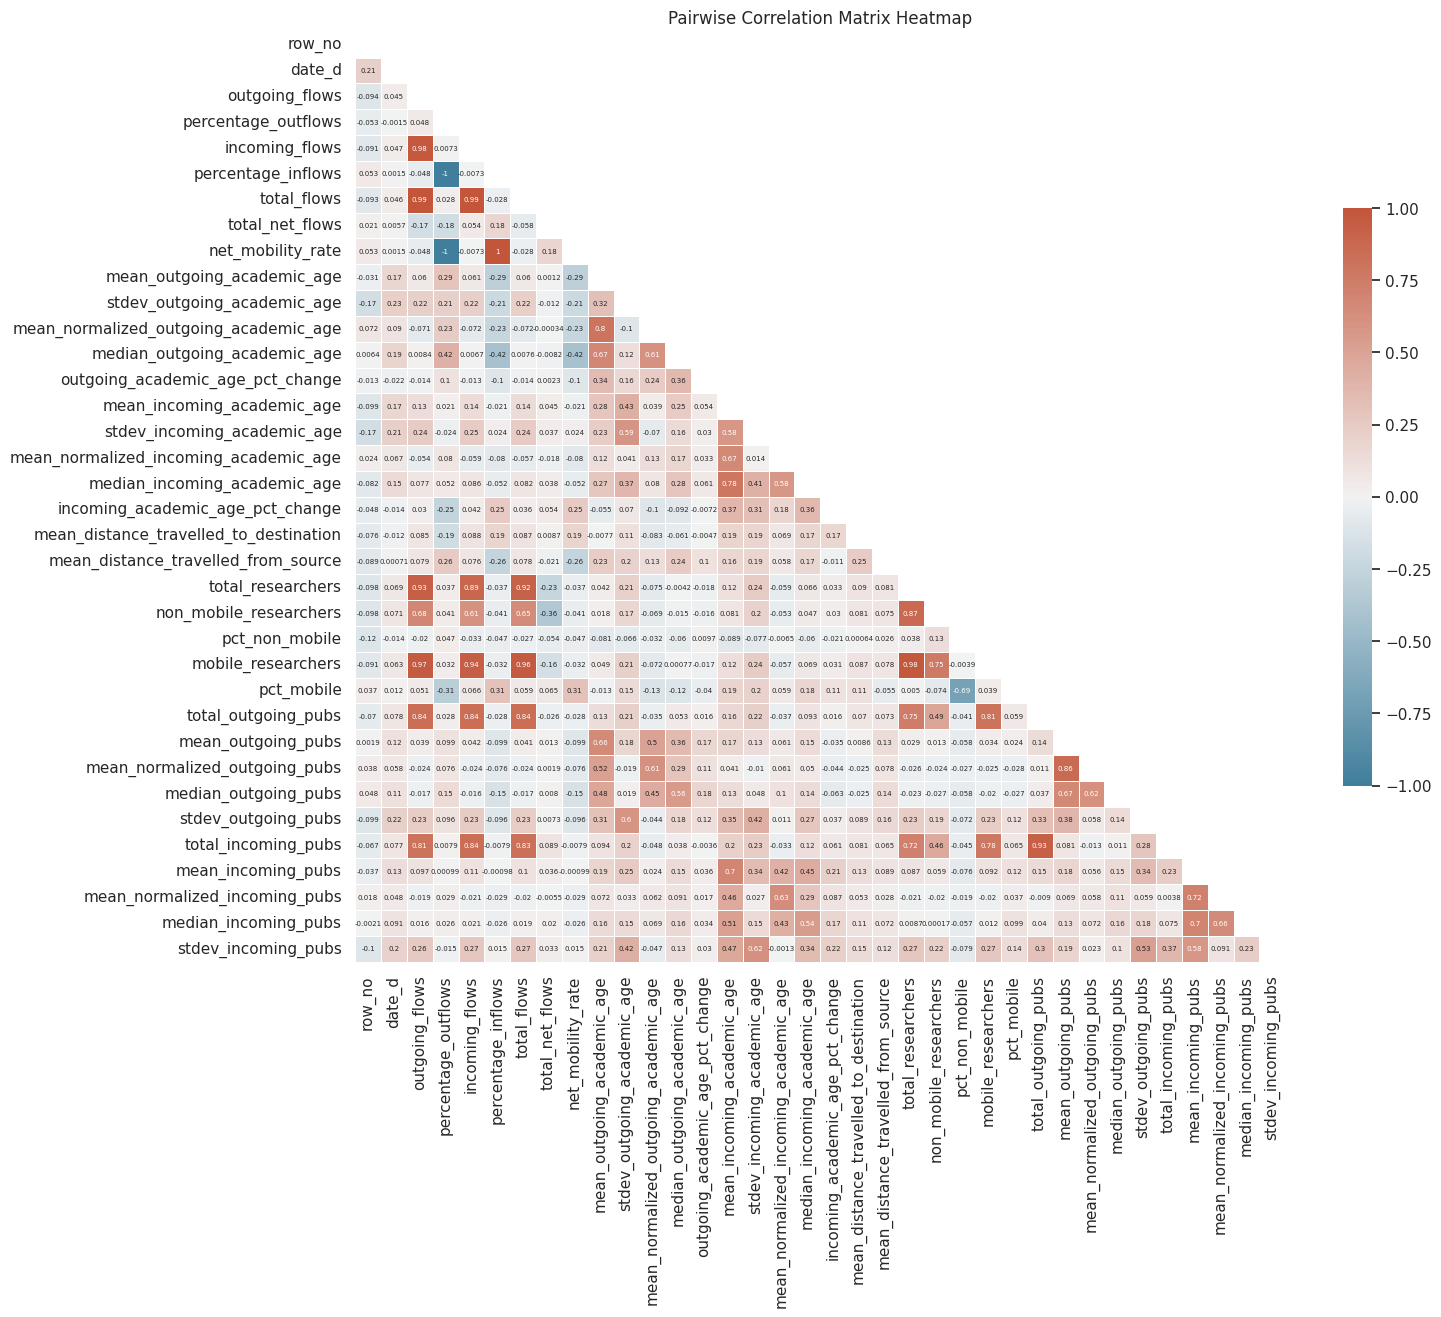

In [30]:
sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, annot_kws={"size": 5})

# Set title and show the plot
plt.title('Pairwise Correlation Matrix Heatmap')
plt.show()

# PART III - Coverage - TBC

1. Validation of trajectories based on ORCID information
2. This is currently work in progress
